In [1]:
%env ALL_PROXY=http://127.0.0.1:33001
%env HTTP_PROXY=http://127.0.0.1:33001
%env HTTPS_PROXY=http://127.0.0.1:33001

env: ALL_PROXY=http://127.0.0.1:33001
env: HTTP_PROXY=http://127.0.0.1:33001
env: HTTPS_PROXY=http://127.0.0.1:33001


In [2]:
!curl google.com

<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="http://www.google.com/">here</A>.
</BODY></HTML>


# Import

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import wandb

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
sys.path.insert(0, "/root/Soil-Column-Procedures")

from API_functions.DL import load_data, log, seed
from API_functions import file_batch as fb

# Hyperparameter and log

In [5]:
my_parameters = {
    'seed': 409,

    'Kfold': None,
    'ratio': 0.2,

    'model': '???',
    'optimizer': 'adam',
    'learning_rate':  0.0001,
    'batch_size': 32,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,
}

device = 'cuda'
mylogger = log.Logger('all')

seed.stablize_seed(my_parameters['seed'])

# Transform

In [6]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# For validation and test data
transform_val = A.Compose([
    ToTensorV2(),
])

# Model

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        # First, calculate the BCE loss
        inputs = torch.sigmoid(inputs)
        bce_loss = self.bce(inputs, targets)
        
        # Calculate Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        # Combine BCE + Dice
        return 0.5 * bce_loss + 0.5 * dice_loss

In [8]:
model = smp.PSPNet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [9]:
# model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
criterion = DiceBCELoss()

# Wandb

In [10]:
wandb.init(
    project="U-Net",
    name='12.using PSPNet',
    config=my_parameters,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laishixuan123 (laishixuan123-china-agricultural-university). Use `wandb login --relogin` to force relogin


# Load_data

In [11]:
data_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_images/', None, 'png')
labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_labels/', None, 'png')


data = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in data_paths]
labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in labels_paths]
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])


train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)


train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}')

10 images have been found in /root/Soil-Column-Procedures/data/version0/train_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12635.png
Get names completely!
10 images have been found in /root/Soil-Column-Procedures/data/version0/train_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12635.png
Get names completely!
len of train_data: 8, len of val_data: 2


# Train

In [12]:
val_loss_best = 100000

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    dict = {'train_loss': train_loss_mean, 'epoch': epoch, 'val_loss': val_loss_mean}
    mylogger.log(dict)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), 'model.pth')
        print(f'Model saved at epoch {epoch}, val_loss: {val_loss_mean}')

  0%|          | 0/1 [00:00<?, ?it/s]/root/Soil-Column-Procedures/API_functions/DL/load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/root/Soil-Column-Procedures/API_functions/DL/load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label/255, dtype=torch.float32)
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


{'epoch': 0, 'train_loss': 0.7342795133590698, 'val_loss': 0.5359091758728027}
Model saved at epoch 0, val_loss: 0.5359091758728027


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


{'epoch': 1, 'train_loss': 0.742646336555481, 'val_loss': 0.525583028793335}
Model saved at epoch 1, val_loss: 0.525583028793335


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 2, 'train_loss': 0.6731189489364624, 'val_loss': 0.5188035368919373}
Model saved at epoch 2, val_loss: 0.5188035368919373


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


{'epoch': 3, 'train_loss': 0.6933164000511169, 'val_loss': 0.5157644152641296}
Model saved at epoch 3, val_loss: 0.5157644152641296


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 4, 'train_loss': 0.6396347284317017, 'val_loss': 0.5152461528778076}
Model saved at epoch 4, val_loss: 0.5152461528778076


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 5, 'train_loss': 0.6271302103996277, 'val_loss': 0.5156863331794739}


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 6, 'train_loss': 0.594768762588501, 'val_loss': 0.5154519081115723}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 7, 'train_loss': 0.5804288983345032, 'val_loss': 0.5139120221138}
Model saved at epoch 7, val_loss: 0.5139120221138


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 8, 'train_loss': 0.5807192921638489, 'val_loss': 0.5112678408622742}
Model saved at epoch 8, val_loss: 0.5112678408622742


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 9, 'train_loss': 0.5707550048828125, 'val_loss': 0.5085629224777222}
Model saved at epoch 9, val_loss: 0.5085629224777222


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 10, 'train_loss': 0.5526077151298523, 'val_loss': 0.5064620971679688}
Model saved at epoch 10, val_loss: 0.5064620971679688


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 11, 'train_loss': 0.5462967157363892, 'val_loss': 0.5063895583152771}
Model saved at epoch 11, val_loss: 0.5063895583152771


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 12, 'train_loss': 0.5314218997955322, 'val_loss': 0.50983065366745}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 13, 'train_loss': 0.5190367698669434, 'val_loss': 0.516155481338501}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 14, 'train_loss': 0.5130679607391357, 'val_loss': 0.5235017538070679}


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 15, 'train_loss': 0.5070359110832214, 'val_loss': 0.5295586585998535}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 16, 'train_loss': 0.4930916726589203, 'val_loss': 0.5340806841850281}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 17, 'train_loss': 0.47894757986068726, 'val_loss': 0.538501501083374}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 18, 'train_loss': 0.4590040147304535, 'val_loss': 0.5407515168190002}


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


{'epoch': 19, 'train_loss': 0.45511287450790405, 'val_loss': 0.5425745844841003}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 20, 'train_loss': 0.4343060553073883, 'val_loss': 0.5423697233200073}


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


{'epoch': 21, 'train_loss': 0.4417996406555176, 'val_loss': 0.5402055978775024}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 22, 'train_loss': 0.4223620295524597, 'val_loss': 0.5404714345932007}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 23, 'train_loss': 0.4100423753261566, 'val_loss': 0.5342541933059692}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 24, 'train_loss': 0.4149196743965149, 'val_loss': 0.5217011570930481}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 25, 'train_loss': 0.38698697090148926, 'val_loss': 0.5093979239463806}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 26, 'train_loss': 0.3744647204875946, 'val_loss': 0.4980485439300537}
Model saved at epoch 26, val_loss: 0.4980485439300537


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 27, 'train_loss': 0.3701365888118744, 'val_loss': 0.48850351572036743}
Model saved at epoch 27, val_loss: 0.48850351572036743


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 28, 'train_loss': 0.36711767315864563, 'val_loss': 0.4757177531719208}
Model saved at epoch 28, val_loss: 0.4757177531719208


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 29, 'train_loss': 0.3481145203113556, 'val_loss': 0.46064069867134094}
Model saved at epoch 29, val_loss: 0.46064069867134094


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 30, 'train_loss': 0.3307875990867615, 'val_loss': 0.4473930895328522}
Model saved at epoch 30, val_loss: 0.4473930895328522


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 31, 'train_loss': 0.33856579661369324, 'val_loss': 0.4350431263446808}
Model saved at epoch 31, val_loss: 0.4350431263446808


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 32, 'train_loss': 0.3222571909427643, 'val_loss': 0.4223886728286743}
Model saved at epoch 32, val_loss: 0.4223886728286743


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 33, 'train_loss': 0.30047187209129333, 'val_loss': 0.4072359800338745}
Model saved at epoch 33, val_loss: 0.4072359800338745


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 34, 'train_loss': 0.3054405450820923, 'val_loss': 0.39693135023117065}
Model saved at epoch 34, val_loss: 0.39693135023117065


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 35,
 'train_loss': 0.29082220792770386,
 'val_loss': 0.39049533009529114}
Model saved at epoch 35, val_loss: 0.39049533009529114


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 36,
 'train_loss': 0.28483009338378906,
 'val_loss': 0.38674771785736084}
Model saved at epoch 36, val_loss: 0.38674771785736084


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

{

'epoch': 37,
 'train_loss': 0.27949172258377075,
 'val_loss': 0.37943705916404724}
Model saved at epoch 37, val_loss: 0.37943705916404724


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 38, 'train_loss': 0.25909295678138733, 'val_loss': 0.3711734414100647}
Model saved at epoch 38, val_loss: 0.3711734414100647


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 39,
 'train_loss': 0.24637144804000854,
 'val_loss': 0.36146673560142517}
Model saved at epoch 39, val_loss: 0.36146673560142517


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 40, 'train_loss': 0.2483854591846466, 'val_loss': 0.35171574354171753}
Model saved at epoch 40, val_loss: 0.35171574354171753


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 41,
 'train_loss': 0.25054270029067993,
 'val_loss': 0.34046685695648193}
Model saved at epoch 41, val_loss: 0.34046685695648193


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 42, 'train_loss': 0.253440260887146, 'val_loss': 0.3281633257865906}
Model saved at epoch 42, val_loss: 0.3281633257865906


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 43, 'train_loss': 0.2426372915506363, 'val_loss': 0.31137582659721375}
Model saved at epoch 43, val_loss: 0.31137582659721375


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 44,
 'train_loss': 0.22502994537353516,
 'val_loss': 0.29455164074897766}
Model saved at epoch 44, val_loss: 0.29455164074897766


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

{'epoch': 45, 'train_loss': 0.2269449681043625, 'val_loss': 0.2795334756374359}


Model saved at epoch 45, val_loss: 0.2795334756374359


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 46,
 'train_loss': 0.22619351744651794,
 'val_loss': 0.26802563667297363}
Model saved at epoch 46, val_loss: 0.26802563667297363


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 47, 'train_loss': 0.22325359284877777, 'val_loss': 0.2580066919326782}
Model saved at epoch 47, val_loss: 0.2580066919326782


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 48, 'train_loss': 0.224227175116539, 'val_loss': 0.2498156875371933}
Model saved at epoch 48, val_loss: 0.2498156875371933


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 49,
 'train_loss': 0.22436952590942383,
 'val_loss': 0.24351024627685547}
Model saved at epoch 49, val_loss: 0.24351024627685547


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 50,
 'train_loss': 0.21395151317119598,
 'val_loss': 0.23853528499603271}
Model saved at epoch 50, val_loss: 0.23853528499603271


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 51,
 'train_loss': 0.20834998786449432,
 'val_loss': 0.23607419431209564}
Model saved at epoch 51, val_loss: 0.23607419431209564


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 52,
 'train_loss': 0.21209782361984253,
 'val_loss': 0.23324447870254517}
Model saved at epoch 52, val_loss: 0.23324447870254517


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

{'epoch': 53, 'train_loss': 0.20690560340881348, 'val_loss': 0.2308008223772049}


Model saved at epoch 53, val_loss: 0.2308008223772049


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 54, 'train_loss': 0.2021113783121109, 'val_loss': 0.22871743142604828}
Model saved at epoch 54, val_loss: 0.22871743142604828


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 55, 'train_loss': 0.19842557609081268, 'val_loss': 0.2262369692325592}
Model saved at epoch 55, val_loss: 0.2262369692325592


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 56,
 'train_loss': 0.20048046112060547,
 'val_loss': 0.22394607961177826}
Model saved at epoch 56, val_loss: 0.22394607961177826


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 57, 'train_loss': 0.1988162100315094, 'val_loss': 0.22116582095623016}
Model saved at epoch 57, val_loss: 0.22116582095623016


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 58, 'train_loss': 0.20356711745262146, 'val_loss': 0.2186276763677597}
Model saved at epoch 58, val_loss: 0.2186276763677597


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 59, 'train_loss': 0.19704383611679077, 'val_loss': 0.2162465751171112}
Model saved at epoch 59, val_loss: 0.2162465751171112


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 60, 'train_loss': 0.199637770652771, 'val_loss': 0.21351924538612366}
Model saved at epoch 60, val_loss: 0.21351924538612366


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 61, 'train_loss': 0.20047616958618164, 'val_loss': 0.2114735096693039}
Model saved at epoch 61, val_loss: 0.2114735096693039


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 62,
 'train_loss': 0.19441108405590057,
 'val_loss': 0.20932134985923767}
Model saved at epoch 62, val_loss: 0.20932134985923767


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 63,
 'train_loss': 0.19362099468708038,
 'val_loss': 0.20745500922203064}
Model saved at epoch 63, val_loss: 0.20745500922203064


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 64, 'train_loss': 0.196466863155365, 'val_loss': 0.2059815675020218}
Model saved at epoch 64, val_loss: 0.2059815675020218


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

{'epoch': 65, 'train_loss': 0.1900910586118698, 'val_loss': 0.20461152493953705}


Model saved at epoch 65, val_loss: 0.20461152493953705


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 66,
 'train_loss': 0.18981678783893585,
 'val_loss': 0.20353376865386963}
Model saved at epoch 66, val_loss: 0.20353376865386963


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 67,
 'train_loss': 0.18399515748023987,
 'val_loss': 0.20226940512657166}
Model saved at epoch 67, val_loss: 0.20226940512657166


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 68,
 'train_loss': 0.18692414462566376,
 'val_loss': 0.20109780132770538}
Model saved at epoch 68, val_loss: 0.20109780132770538


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 69,
 'train_loss': 0.18776896595954895,
 'val_loss': 0.19993574917316437}
Model saved at epoch 69, val_loss: 0.19993574917316437


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


{'epoch': 70, 'train_loss': 0.190142422914505, 'val_loss': 0.19870588183403015}
Model saved at epoch 70, val_loss: 0.19870588183403015


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

{'epoch': 71,
 'train_loss': 0.18519723415374756,
 'val_loss': 0.19800665974617004}


Model saved at epoch 71, val_loss: 0.19800665974617004


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 72,
 'train_loss': 0.18656077980995178,
 'val_loss': 0.19755518436431885}
Model saved at epoch 72, val_loss: 0.19755518436431885


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 73, 'train_loss': 0.1868150383234024, 'val_loss': 0.19722875952720642}
Model saved at epoch 73, val_loss: 0.19722875952720642


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 74, 'train_loss': 0.1808377355337143, 'val_loss': 0.19641458988189697}
Model saved at epoch 74, val_loss: 0.19641458988189697


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 75,
 'train_loss': 0.19036689400672913,
 'val_loss': 0.19514065980911255}
Model saved at epoch 75, val_loss: 0.19514065980911255


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 76, 'train_loss': 0.1885225921869278, 'val_loss': 0.19381943345069885}
Model saved at epoch 76, val_loss: 0.19381943345069885


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 77,
 'train_loss': 0.18630851805210114,
 'val_loss': 0.19287718832492828}
Model saved at epoch 77, val_loss: 0.19287718832492828


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


{'epoch': 78,
 'train_loss': 0.18016992509365082,
 'val_loss': 0.19205732643604279}
Model saved at epoch 78, val_loss: 0.19205732643604279


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 79, 'train_loss': 0.18331082165241241, 'val_loss': 0.1909283697605133}
Model saved at epoch 79, val_loss: 0.1909283697605133


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 80,
 'train_loss': 0.18421262502670288,
 'val_loss': 0.19084197282791138}
Model saved at epoch 80, val_loss: 0.19084197282791138


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 81, 'train_loss': 0.18322300910949707, 'val_loss': 0.1904037594795227}
Model saved at epoch 81, val_loss: 0.1904037594795227


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 82, 'train_loss': 0.1829587072134018, 'val_loss': 0.18990640342235565}
Model saved at epoch 82, val_loss: 0.18990640342235565


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 83, 'train_loss': 0.18368251621723175, 'val_loss': 0.1897706836462021}
Model saved at epoch 83, val_loss: 0.1897706836462021


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 84, 'train_loss': 0.1821100413799286, 'val_loss': 0.19053232669830322}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 85, 'train_loss': 0.1810804158449173, 'val_loss': 0.18958856165409088}
Model saved at epoch 85, val_loss: 0.18958856165409088


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 86,
 'train_loss': 0.18182769417762756,
 'val_loss': 0.18766199052333832}
Model saved at epoch 86, val_loss: 0.18766199052333832


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 87, 'train_loss': 0.1818975806236267, 'val_loss': 0.186132550239563}
Model saved at epoch 87, val_loss: 0.186132550239563


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 88,
 'train_loss': 0.17537742853164673,
 'val_loss': 0.18590939044952393}
Model saved at epoch 88, val_loss: 0.18590939044952393


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 89,
 'train_loss': 0.17967139184474945,
 'val_loss': 0.18734155595302582}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 90, 'train_loss': 0.17249560356140137, 'val_loss': 0.1888624131679535}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 91,
 'train_loss': 0.17366066575050354,
 'val_loss': 0.19059666991233826}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 92,
 'train_loss': 0.17619989812374115,
 'val_loss': 0.19196894764900208}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 93,
 'train_loss': 0.17483074963092804,
 'val_loss': 0.19350403547286987}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 94, 'train_loss': 0.1788315325975418, 'val_loss': 0.19403263926506042}


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


{'epoch': 95, 'train_loss': 0.16621068120002747, 'val_loss': 0.1931261420249939}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 96,
 'train_loss': 0.17887862026691437,
 'val_loss': 0.19168712198734283}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 97,
 'train_loss': 0.17790277302265167,
 'val_loss': 0.19098308682441711}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 98, 'train_loss': 0.17275018990039825, 'val_loss': 0.1903829723596573}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 99, 'train_loss': 0.17033368349075317, 'val_loss': 0.1892494410276413}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 100,
 'train_loss': 0.17666074633598328,
 'val_loss': 0.18800219893455505}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 101,
 'train_loss': 0.17670844495296478,
 'val_loss': 0.18706759810447693}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 102,
 'train_loss': 0.17681285738945007,
 'val_loss': 0.18542098999023438}
Model saved at epoch 102, val_loss: 0.18542098999023438


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 103,
 'train_loss': 0.17070220410823822,
 'val_loss': 0.18414422869682312}
Model saved at epoch 103, val_loss: 0.18414422869682312


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

{'epoch': 104,
 'train_loss': 0.16733911633491516,
 'val_loss': 0.1829499900341034}


Model saved at epoch 104, val_loss: 0.1829499900341034


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 105,
 'train_loss': 0.16734954714775085,
 'val_loss': 0.18131479620933533}
Model saved at epoch 105, val_loss: 0.18131479620933533


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 106,
 'train_loss': 0.16996058821678162,
 'val_loss': 0.18005572259426117}
Model saved at epoch 106, val_loss: 0.18005572259426117


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 107,
 'train_loss': 0.17614197731018066,
 'val_loss': 0.1793486773967743}
Model saved at epoch 107, val_loss: 0.1793486773967743


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 108,
 'train_loss': 0.17883531749248505,
 'val_loss': 0.17947709560394287}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 109,
 'train_loss': 0.1755291074514389,
 'val_loss': 0.17958718538284302}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 110,
 'train_loss': 0.1651267260313034,
 'val_loss': 0.17978987097740173}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 111,
 'train_loss': 0.16833777725696564,
 'val_loss': 0.17998245358467102}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 112,
 'train_loss': 0.1651909351348877,
 'val_loss': 0.18003790080547333}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 113,
 'train_loss': 0.17034342885017395,
 'val_loss': 0.18043522536754608}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 114,
 'train_loss': 0.17144735157489777,
 'val_loss': 0.18081893026828766}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 115,
 'train_loss': 0.17107170820236206,
 'val_loss': 0.18155284225940704}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 116,
 'train_loss': 0.1774844527244568,
 'val_loss': 0.18202336132526398}


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


{'epoch': 117,
 'train_loss': 0.16365009546279907,
 'val_loss': 0.18238575756549835}


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


{'epoch': 118,
 'train_loss': 0.16828447580337524,
 'val_loss': 0.18357659876346588}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 119,
 'train_loss': 0.1655300110578537,
 'val_loss': 0.18423864245414734}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 120,
 'train_loss': 0.17026209831237793,
 'val_loss': 0.1829647570848465}


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


{'epoch': 121,
 'train_loss': 0.16482804715633392,
 'val_loss': 0.18103668093681335}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 122,
 'train_loss': 0.17291715741157532,
 'val_loss': 0.17905570566654205}
Model saved at epoch 122, val_loss: 0.17905570566654205


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

{'epoch': 123,
 'train_loss': 0.16622793674468994,
 'val_loss': 0.17818570137023926}


Model saved at epoch 123, val_loss: 0.17818570137023926


100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


{'epoch': 124,
 'train_loss': 0.15969792008399963,
 'val_loss': 0.17850615084171295}


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


{'epoch': 125,
 'train_loss': 0.1729399710893631,
 'val_loss': 0.17839010059833527}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 126,
 'train_loss': 0.16281463205814362,
 'val_loss': 0.17902086675167084}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 127,
 'train_loss': 0.15858958661556244,
 'val_loss': 0.1797516942024231}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 128, 'train_loss': 0.16411587595939636, 'val_loss': 0.181399405002594}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 129,
 'train_loss': 0.16424521803855896,
 'val_loss': 0.1831180900335312}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 130,
 'train_loss': 0.16745507717132568,
 'val_loss': 0.18185387551784515}


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


{'epoch': 131,
 'train_loss': 0.1630326509475708,
 'val_loss': 0.18189048767089844}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 132,
 'train_loss': 0.16772478818893433,
 'val_loss': 0.18051601946353912}


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


{'epoch': 133,
 'train_loss': 0.16420069336891174,
 'val_loss': 0.18097208440303802}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 134,
 'train_loss': 0.16107122600078583,
 'val_loss': 0.18226614594459534}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 135,
 'train_loss': 0.16132915019989014,
 'val_loss': 0.18455909192562103}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 136,
 'train_loss': 0.16090954840183258,
 'val_loss': 0.18667341768741608}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 137,
 'train_loss': 0.17133460938930511,
 'val_loss': 0.18934540450572968}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 138,
 'train_loss': 0.16500341892242432,
 'val_loss': 0.19386392831802368}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 139,
 'train_loss': 0.16253890097141266,
 'val_loss': 0.20014230906963348}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 140,
 'train_loss': 0.16424252092838287,
 'val_loss': 0.1995919942855835}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 141,
 'train_loss': 0.15341109037399292,
 'val_loss': 0.19887959957122803}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 142,
 'train_loss': 0.15669450163841248,
 'val_loss': 0.1973269134759903}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 143,
 'train_loss': 0.16034042835235596,
 'val_loss': 0.19192282855510712}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 144,
 'train_loss': 0.15471872687339783,
 'val_loss': 0.18743492662906647}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 145,
 'train_loss': 0.15880124270915985,
 'val_loss': 0.1840912401676178}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 146,
 'train_loss': 0.15562385320663452,
 'val_loss': 0.18258784711360931}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 147,
 'train_loss': 0.16793209314346313,
 'val_loss': 0.18164263665676117}


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


{'epoch': 148,
 'train_loss': 0.16002075374126434,
 'val_loss': 0.1786733865737915}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 149,
 'train_loss': 0.16749484837055206,
 'val_loss': 0.17600494623184204}
Model saved at epoch 149, val_loss: 0.17600494623184204


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 150,
 'train_loss': 0.15473246574401855,
 'val_loss': 0.17503952980041504}
Model saved at epoch 150, val_loss: 0.17503952980041504


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 151,
 'train_loss': 0.14881305396556854,
 'val_loss': 0.17514094710350037}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 152,
 'train_loss': 0.1584811806678772,
 'val_loss': 0.17341738939285278}
Model saved at epoch 152, val_loss: 0.17341738939285278


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 153,
 'train_loss': 0.1587633490562439,
 'val_loss': 0.17202749848365784}
Model saved at epoch 153, val_loss: 0.17202749848365784


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 154,
 'train_loss': 0.15977124869823456,
 'val_loss': 0.17016290128231049}
Model saved at epoch 154, val_loss: 0.17016290128231049


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 155,
 'train_loss': 0.1581863909959793,
 'val_loss': 0.16929364204406738}
Model saved at epoch 155, val_loss: 0.16929364204406738


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 156,
 'train_loss': 0.14969292283058167,
 'val_loss': 0.1696910560131073}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 157,
 'train_loss': 0.15525533258914948,
 'val_loss': 0.1723695993423462}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 158,
 'train_loss': 0.1620771437883377,
 'val_loss': 0.17303551733493805}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 159, 'train_loss': 0.1544804722070694, 'val_loss': 0.1733880490064621}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 160,
 'train_loss': 0.1505262553691864,
 'val_loss': 0.17132526636123657}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 161,
 'train_loss': 0.15173403918743134,
 'val_loss': 0.16974516212940216}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 162,
 'train_loss': 0.1601581871509552,
 'val_loss': 0.16864585876464844}
Model saved at epoch 162, val_loss: 0.16864585876464844


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

{

'epoch': 163,
 'train_loss': 0.15435339510440826,
 'val_loss': 0.16779416799545288}
Model saved at epoch 163, val_loss: 0.16779416799545288


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 164,
 'train_loss': 0.15732334554195404,
 'val_loss': 0.1665479689836502}
Model saved at epoch 164, val_loss: 0.1665479689836502


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


{'epoch': 165,
 'train_loss': 0.16539031267166138,
 'val_loss': 0.16781632602214813}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 166,
 'train_loss': 0.14753185212612152,
 'val_loss': 0.16852591931819916}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 167,
 'train_loss': 0.1612655222415924,
 'val_loss': 0.17225004732608795}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 168,
 'train_loss': 0.15676429867744446,
 'val_loss': 0.1764197051525116}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 169,
 'train_loss': 0.15013565123081207,
 'val_loss': 0.17539002001285553}


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


{'epoch': 170,
 'train_loss': 0.15718591213226318,
 'val_loss': 0.1755400449037552}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 171,
 'train_loss': 0.15393592417240143,
 'val_loss': 0.17294295132160187}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 172,
 'train_loss': 0.14557099342346191,
 'val_loss': 0.17295882105827332}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 173,
 'train_loss': 0.15530888736248016,
 'val_loss': 0.17039549350738525}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 174,
 'train_loss': 0.14256469905376434,
 'val_loss': 0.16788212954998016}


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


{'epoch': 175,
 'train_loss': 0.14399126172065735,
 'val_loss': 0.16745279729366302}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 176,
 'train_loss': 0.1467689424753189,
 'val_loss': 0.16911962628364563}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 177, 'train_loss': 0.15225869417190552, 'val_loss': 0.169899582862854}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 178,
 'train_loss': 0.16045327484607697,
 'val_loss': 0.1665230393409729}
Model saved at epoch 178, val_loss: 0.1665230393409729


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 179,
 'train_loss': 0.15660807490348816,
 'val_loss': 0.16251090168952942}
Model saved at epoch 179, val_loss: 0.16251090168952942


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 180,
 'train_loss': 0.15554288029670715,
 'val_loss': 0.1626787930727005}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 181,
 'train_loss': 0.16362568736076355,
 'val_loss': 0.16541136801242828}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 182,
 'train_loss': 0.1532258689403534,
 'val_loss': 0.16884729266166687}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

{'epoch'

: 183,
 'train_loss': 0.15407750010490417,
 'val_loss': 0.17137782275676727}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 184,
 'train_loss': 0.1540406346321106,
 'val_loss': 0.17905986309051514}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 185,
 'train_loss': 0.15397797524929047,
 'val_loss': 0.1897258460521698}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 186,
 'train_loss': 0.16074271500110626,
 'val_loss': 0.17795202136039734}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 187,
 'train_loss': 0.1434529721736908,
 'val_loss': 0.16216479241847992}
Model saved at epoch 187, val_loss: 0.16216479241847992


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 188,
 'train_loss': 0.14362260699272156,
 'val_loss': 0.15722109377384186}
Model saved at epoch 188, val_loss: 0.15722109377384186


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

{'epoch': 189,
 'train_loss': 0.1403769552707672,
 'val_loss': 0.15618377923965454}


Model saved at epoch 189, val_loss: 0.15618377923965454


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 190,
 'train_loss': 0.15681107342243195,
 'val_loss': 0.15573622286319733}
Model saved at epoch 190, val_loss: 0.15573622286319733


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


{'epoch': 191,
 'train_loss': 0.15604670345783234,
 'val_loss': 0.15589894354343414}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 192,
 'train_loss': 0.15302497148513794,
 'val_loss': 0.15589994192123413}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 193,
 'train_loss': 0.15136712789535522,
 'val_loss': 0.15514761209487915}
Model saved at epoch 193, val_loss: 0.15514761209487915


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


{'epoch': 194,
 'train_loss': 0.15674327313899994,
 'val_loss': 0.1550757884979248}
Model saved at epoch 194, val_loss: 0.1550757884979248


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 195,
 'train_loss': 0.1471855342388153,
 'val_loss': 0.15524519979953766}


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


{'epoch': 196,
 'train_loss': 0.14311203360557556,
 'val_loss': 0.1568949669599533}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 197,
 'train_loss': 0.15038205683231354,
 'val_loss': 0.15962016582489014}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 198,
 'train_loss': 0.1419207751750946,
 'val_loss': 0.16311684250831604}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 199,
 'train_loss': 0.15537527203559875,
 'val_loss': 0.1643276810646057}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 200, 'train_loss': 0.1432131975889206, 'val_loss': 0.1631169617176056}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 201,
 'train_loss': 0.14557985961437225,
 'val_loss': 0.16554677486419678}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 202,
 'train_loss': 0.14607688784599304,
 'val_loss': 0.16474194824695587}


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


{'epoch': 203,
 'train_loss': 0.14733077585697174,
 'val_loss': 0.16223761439323425}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 204,
 'train_loss': 0.1397387981414795,
 'val_loss': 0.16225656867027283}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 205,
 'train_loss': 0.14362095296382904,
 'val_loss': 0.16196927428245544}


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


{'epoch': 206,
 'train_loss': 0.1457618772983551,
 'val_loss': 0.16124814748764038}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 207,
 'train_loss': 0.16056738793849945,
 'val_loss': 0.1583537757396698}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 208,
 'train_loss': 0.15321899950504303,
 'val_loss': 0.15952035784721375}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 209,
 'train_loss': 0.14299386739730835,
 'val_loss': 0.16413624584674835}


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


{'epoch': 210,
 'train_loss': 0.13518567383289337,
 'val_loss': 0.17075850069522858}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 211, 'train_loss': 0.15648923814296722, 'val_loss': 0.184127077460289}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 212,
 'train_loss': 0.14794835448265076,
 'val_loss': 0.19688959419727325}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 213,
 'train_loss': 0.14354020357131958,
 'val_loss': 0.2067541927099228}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 214,
 'train_loss': 0.1500338464975357,
 'val_loss': 0.21231257915496826}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 215,
 'train_loss': 0.13894107937812805,
 'val_loss': 0.20127452909946442}


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


{'epoch': 216,
 'train_loss': 0.13842765986919403,
 'val_loss': 0.18303091824054718}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 217,
 'train_loss': 0.15341202914714813,
 'val_loss': 0.16634529829025269}


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


{'epoch': 218,
 'train_loss': 0.16068562865257263,
 'val_loss': 0.1563110053539276}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 219,
 'train_loss': 0.14732669293880463,
 'val_loss': 0.15433312952518463}
Model saved at epoch 219, val_loss: 0.15433312952518463


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 220, 'train_loss': 0.1509087234735489, 'val_loss': 0.1546209305524826}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 221,
 'train_loss': 0.13715028762817383,
 'val_loss': 0.15535037219524384}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 222,
 'train_loss': 0.14138400554656982,
 'val_loss': 0.15787997841835022}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 223,
 'train_loss': 0.14290933310985565,
 'val_loss': 0.16217058897018433}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 224,
 'train_loss': 0.15643657743930817,
 'val_loss': 0.16352573037147522}


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


{'epoch': 225,
 'train_loss': 0.14001207053661346,
 'val_loss': 0.15906818211078644}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 226,
 'train_loss': 0.14399026334285736,
 'val_loss': 0.15740805864334106}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 227, 'train_loss': 0.154199481010437, 'val_loss': 0.15659278631210327}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 228,
 'train_loss': 0.15257516503334045,
 'val_loss': 0.1573258936405182}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 229,
 'train_loss': 0.14035166800022125,
 'val_loss': 0.15685825049877167}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 230,
 'train_loss': 0.14444109797477722,
 'val_loss': 0.15505115687847137}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

{'epoch': 231,
 'train_loss': 0.14790880680084229,
 'val_loss': 0.1561860889196396}



100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


{'epoch': 232,
 'train_loss': 0.1316547691822052,
 'val_loss': 0.15570949018001556}


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


{'epoch': 233,
 'train_loss': 0.14569172263145447,
 'val_loss': 0.15539142489433289}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

{

'epoch': 234,
 'train_loss': 0.14146175980567932,
 'val_loss': 0.15414705872535706}
Model saved at epoch 234, val_loss: 0.15414705872535706


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 235, 'train_loss': 0.142996147274971, 'val_loss': 0.1527796983718872}
Model saved at epoch 235, val_loss: 0.1527796983718872


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 236,
 'train_loss': 0.14751382172107697,
 'val_loss': 0.15189263224601746}
Model saved at epoch 236, val_loss: 0.15189263224601746


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 237,
 'train_loss': 0.15184254944324493,
 'val_loss': 0.15246574580669403}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 238,
 'train_loss': 0.14033325016498566,
 'val_loss': 0.1534377485513687}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 239,
 'train_loss': 0.14892223477363586,
 'val_loss': 0.15285849571228027}


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


{'epoch': 240,
 'train_loss': 0.13516126573085785,
 'val_loss': 0.15283174812793732}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 241,
 'train_loss': 0.1454477608203888,
 'val_loss': 0.15452006459236145}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 242, 'train_loss': 0.1495002955198288, 'val_loss': 0.1564038097858429}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 243,
 'train_loss': 0.13739913702011108,
 'val_loss': 0.15683694183826447}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 244,
 'train_loss': 0.12738586962223053,
 'val_loss': 0.15661948919296265}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 245,
 'train_loss': 0.14113110303878784,
 'val_loss': 0.1560770869255066}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 246,
 'train_loss': 0.15108026564121246,
 'val_loss': 0.1547660529613495}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 247,
 'train_loss': 0.13423603773117065,
 'val_loss': 0.15364883840084076}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 248,
 'train_loss': 0.14022338390350342,
 'val_loss': 0.1524716168642044}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 249,
 'train_loss': 0.13812614977359772,
 'val_loss': 0.15203633904457092}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 250,
 'train_loss': 0.1355617195367813,
 'val_loss': 0.15215256810188293}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 251,
 'train_loss': 0.1495049148797989,
 'val_loss': 0.15514953434467316}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

{

'epoch': 252,
 'train_loss': 0.1358124166727066,
 'val_loss': 0.15888729691505432}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 253,
 'train_loss': 0.13426844775676727,
 'val_loss': 0.16381265223026276}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 254,
 'train_loss': 0.1437418907880783,
 'val_loss': 0.16272184252738953}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 255,
 'train_loss': 0.15021668374538422,
 'val_loss': 0.15760953724384308}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 256,
 'train_loss': 0.14555160701274872,
 'val_loss': 0.1522437185049057}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

{'epoch': 257,
 'train_loss': 0.13252009451389313,
 'val_loss': 0.1494854986667633}


Model saved at epoch 257, val_loss: 0.1494854986667633


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 258,
 'train_loss': 0.1440804898738861,
 'val_loss': 0.14776422083377838}
Model saved at epoch 258, val_loss: 0.14776422083377838


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 259,
 'train_loss': 0.1552782952785492,
 'val_loss': 0.14688268303871155}
Model saved at epoch 259, val_loss: 0.14688268303871155


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 260,
 'train_loss': 0.13265815377235413,
 'val_loss': 0.15128688514232635}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 261,
 'train_loss': 0.14546772837638855,
 'val_loss': 0.15684181451797485}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 262,
 'train_loss': 0.1427081823348999,
 'val_loss': 0.16265425086021423}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 263,
 'train_loss': 0.1360733062028885,
 'val_loss': 0.16169938445091248}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 264,
 'train_loss': 0.13652567565441132,
 'val_loss': 0.16059620678424835}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 265, 'train_loss': 0.145623117685318, 'val_loss': 0.15746909379959106}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 266,
 'train_loss': 0.13835465908050537,
 'val_loss': 0.1525285243988037}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 267,
 'train_loss': 0.14970184862613678,
 'val_loss': 0.14799535274505615}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 268,
 'train_loss': 0.13411667943000793,
 'val_loss': 0.14665034413337708}
Model saved at epoch 268, val_loss: 0.14665034413337708


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 269,
 'train_loss': 0.15069061517715454,
 'val_loss': 0.1475033164024353}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 270,
 'train_loss': 0.14131644368171692,
 'val_loss': 0.15041561424732208}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 271,
 'train_loss': 0.13985338807106018,
 'val_loss': 0.15504209697246552}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 272,
 'train_loss': 0.13564786314964294,
 'val_loss': 0.15675917267799377}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 273,
 'train_loss': 0.13559140264987946,
 'val_loss': 0.15167102217674255}


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


{'epoch': 274,
 'train_loss': 0.13892652094364166,
 'val_loss': 0.15247967839241028}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 275,
 'train_loss': 0.14038512110710144,
 'val_loss': 0.15669235587120056}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 276,
 'train_loss': 0.14398826658725739,
 'val_loss': 0.16178184747695923}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 277,
 'train_loss': 0.14146815240383148,
 'val_loss': 0.16557365655899048}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 278,
 'train_loss': 0.1312490999698639,
 'val_loss': 0.16046927869319916}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 279,
 'train_loss': 0.14317792654037476,
 'val_loss': 0.15282145142555237}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 280,
 'train_loss': 0.13512396812438965,
 'val_loss': 0.1498688906431198}


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


{'epoch': 281,
 'train_loss': 0.13130225241184235,
 'val_loss': 0.14973485469818115}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 282,
 'train_loss': 0.13518370687961578,
 'val_loss': 0.15285049378871918}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 283,
 'train_loss': 0.13947394490242004,
 'val_loss': 0.1583096981048584}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 284,
 'train_loss': 0.13442711532115936,
 'val_loss': 0.1639108657836914}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 285, 'train_loss': 0.1496969312429428, 'val_loss': 0.1613677591085434}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 286,
 'train_loss': 0.1345958113670349,
 'val_loss': 0.15556016564369202}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 287,
 'train_loss': 0.1354912668466568,
 'val_loss': 0.14852598309516907}


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


{'epoch': 288,
 'train_loss': 0.13424064218997955,
 'val_loss': 0.14834405481815338}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 289,
 'train_loss': 0.1344764232635498,
 'val_loss': 0.15015411376953125}


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


{'epoch': 290,
 'train_loss': 0.13170912861824036,
 'val_loss': 0.15188735723495483}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 291,
 'train_loss': 0.13105234503746033,
 'val_loss': 0.15234246850013733}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 292,
 'train_loss': 0.13881038129329681,
 'val_loss': 0.1483985185623169}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 293,
 'train_loss': 0.1250305026769638,
 'val_loss': 0.14631551504135132}
Model saved at epoch 293, val_loss: 0.14631551504135132


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 294,
 'train_loss': 0.14601652324199677,
 'val_loss': 0.14681488275527954}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 295,
 'train_loss': 0.12605640292167664,
 'val_loss': 0.14848244190216064}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 296,
 'train_loss': 0.13224852085113525,
 'val_loss': 0.15245307981967926}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 297,
 'train_loss': 0.13514380156993866,
 'val_loss': 0.15437304973602295}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 298,
 'train_loss': 0.14556045830249786,
 'val_loss': 0.1513766497373581}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 299, 'train_loss': 0.1455255150794983, 'val_loss': 0.1467900425195694}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 300, 'train_loss': 0.140523299574852, 'val_loss': 0.14791160821914673}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 301,
 'train_loss': 0.12786629796028137,
 'val_loss': 0.14873665571212769}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 302,
 'train_loss': 0.13477875292301178,
 'val_loss': 0.15063467621803284}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 303,
 'train_loss': 0.13338404893875122,
 'val_loss': 0.1592625230550766}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 304,
 'train_loss': 0.13642939925193787,
 'val_loss': 0.17642153799533844}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 305,
 'train_loss': 0.1310681402683258,
 'val_loss': 0.20076505839824677}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 306,
 'train_loss': 0.1465349942445755,
 'val_loss': 0.18096323311328888}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 307,
 'train_loss': 0.15468287467956543,
 'val_loss': 0.1583116203546524}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 308,
 'train_loss': 0.1469748467206955,
 'val_loss': 0.15048010647296906}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 309, 'train_loss': 0.1325433850288391, 'val_loss': 0.1512053906917572}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


{'epoch': 310,
 'train_loss': 0.1297105848789215,
 'val_loss': 0.15139038860797882}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 311,
 'train_loss': 0.14161984622478485,
 'val_loss': 0.15116265416145325}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 312,
 'train_loss': 0.13088947534561157,
 'val_loss': 0.15449312329292297}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 313,
 'train_loss': 0.12768879532814026,
 'val_loss': 0.15979349613189697}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 314, 'train_loss': 0.1284233033657074, 'val_loss': 0.1573983132839203}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 315,
 'train_loss': 0.13673076033592224,
 'val_loss': 0.14961709082126617}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 316,
 'train_loss': 0.14349567890167236,
 'val_loss': 0.14302973449230194}
Model saved at epoch 316, val_loss: 0.14302973449230194


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 317,
 'train_loss': 0.1315828561782837,
 'val_loss': 0.14431551098823547}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 318,
 'train_loss': 0.1336251050233841,
 'val_loss': 0.14691931009292603}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 319,
 'train_loss': 0.12324506044387817,
 'val_loss': 0.14835865795612335}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 320,
 'train_loss': 0.12710773944854736,
 'val_loss': 0.14832791686058044}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 321,
 'train_loss': 0.13089890778064728,
 'val_loss': 0.1485966593027115}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

{

'epoch': 322,
 'train_loss': 0.1264103353023529,
 'val_loss': 0.14946570992469788}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 323,
 'train_loss': 0.13169118762016296,
 'val_loss': 0.1513969749212265}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 324,
 'train_loss': 0.12207333743572235,
 'val_loss': 0.15004125237464905}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 325, 'train_loss': 0.1316118687391281, 'val_loss': 0.1481368988752365}


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


{'epoch': 326,
 'train_loss': 0.11780016124248505,
 'val_loss': 0.14701946079730988}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 327,
 'train_loss': 0.14978544414043427,
 'val_loss': 0.14715905487537384}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 328, 'train_loss': 0.1304929107427597, 'val_loss': 0.1464540958404541}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 329,
 'train_loss': 0.12263987213373184,
 'val_loss': 0.14742109179496765}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 330,
 'train_loss': 0.12923550605773926,
 'val_loss': 0.15318609774112701}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 331,
 'train_loss': 0.13476607203483582,
 'val_loss': 0.15706728398799896}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 332,
 'train_loss': 0.1374613642692566,
 'val_loss': 0.15251301229000092}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 333,
 'train_loss': 0.13797599077224731,
 'val_loss': 0.14879310131072998}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 334,
 'train_loss': 0.14636288583278656,
 'val_loss': 0.14628593623638153}


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


{'epoch': 335,
 'train_loss': 0.11742394417524338,
 'val_loss': 0.14526350796222687}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 336,
 'train_loss': 0.13593032956123352,
 'val_loss': 0.14463241398334503}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 337,
 'train_loss': 0.12512953579425812,
 'val_loss': 0.14277654886245728}
Model saved at epoch 337, val_loss: 0.14277654886245728


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 338,
 'train_loss': 0.13072124123573303,
 'val_loss': 0.14100679755210876}
Model saved at epoch 338, val_loss: 0.14100679755210876


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 339,
 'train_loss': 0.13361789286136627,
 'val_loss': 0.14174747467041016}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 340,
 'train_loss': 0.13876307010650635,
 'val_loss': 0.14870654046535492}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 341,
 'train_loss': 0.1234554573893547,
 'val_loss': 0.15144217014312744}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 342,
 'train_loss': 0.12822315096855164,
 'val_loss': 0.15001115202903748}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 343,
 'train_loss': 0.13986749947071075,
 'val_loss': 0.14605413377285004}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 344,
 'train_loss': 0.13935784995555878,
 'val_loss': 0.14374083280563354}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 345, 'train_loss': 0.1468813717365265, 'val_loss': 0.1445126235485077}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 346,
 'train_loss': 0.13176697492599487,
 'val_loss': 0.14736966788768768}


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


{'epoch': 347,
 'train_loss': 0.14233332872390747,
 'val_loss': 0.14618372917175293}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 348,
 'train_loss': 0.11800259351730347,
 'val_loss': 0.1456708014011383}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 349,
 'train_loss': 0.13538828492164612,
 'val_loss': 0.14682628214359283}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 350,
 'train_loss': 0.13526460528373718,
 'val_loss': 0.14887499809265137}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 351,
 'train_loss': 0.12582731246948242,
 'val_loss': 0.14958366751670837}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 352,
 'train_loss': 0.11466395854949951,
 'val_loss': 0.1511584222316742}


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


{'epoch': 353,
 'train_loss': 0.13807396590709686,
 'val_loss': 0.15282824635505676}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 354,
 'train_loss': 0.12919361889362335,
 'val_loss': 0.14565011858940125}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 355,
 'train_loss': 0.13189293444156647,
 'val_loss': 0.14167900383472443}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 356,
 'train_loss': 0.13305354118347168,
 'val_loss': 0.14213985204696655}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 357,
 'train_loss': 0.13291923701763153,
 'val_loss': 0.14282530546188354}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 358,
 'train_loss': 0.13001863658428192,
 'val_loss': 0.1429816484451294}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 359,
 'train_loss': 0.13848654925823212,
 'val_loss': 0.14380264282226562}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 360,
 'train_loss': 0.12415440380573273,
 'val_loss': 0.14380356669425964}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 361,
 'train_loss': 0.1367742419242859,
 'val_loss': 0.14977353811264038}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 362,
 'train_loss': 0.1256103217601776,
 'val_loss': 0.15396174788475037}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 363,
 'train_loss': 0.1431158035993576,
 'val_loss': 0.15073814988136292}


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


{'epoch': 364,
 'train_loss': 0.12674753367900848,
 'val_loss': 0.14498186111450195}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

{'epoch': 365,
 'train_loss': 0.1277034431695938,
 'val_loss': 0.13945259153842926}


Model saved at epoch 365, val_loss: 0.13945259153842926


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 366,
 'train_loss': 0.13420356810092926,
 'val_loss': 0.1380411982536316}
Model saved at epoch 366, val_loss: 0.1380411982536316


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 367,
 'train_loss': 0.12216677516698837,
 'val_loss': 0.13898465037345886}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 368, 'train_loss': 0.146946519613266, 'val_loss': 0.14389799535274506}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 369,
 'train_loss': 0.13484638929367065,
 'val_loss': 0.15297652781009674}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 370,
 'train_loss': 0.13019369542598724,
 'val_loss': 0.15268053114414215}


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


{'epoch': 371,
 'train_loss': 0.11596698313951492,
 'val_loss': 0.1417561173439026}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 372,
 'train_loss': 0.12836748361587524,
 'val_loss': 0.14060629904270172}


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


{'epoch': 373, 'train_loss': 0.1327943056821823, 'val_loss': 0.1485951989889145}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 374,
 'train_loss': 0.13050025701522827,
 'val_loss': 0.15130901336669922}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 375,
 'train_loss': 0.12656578421592712,
 'val_loss': 0.14540134370326996}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 376,
 'train_loss': 0.13357435166835785,
 'val_loss': 0.13997113704681396}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 377,
 'train_loss': 0.12539584934711456,
 'val_loss': 0.14150817692279816}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 378,
 'train_loss': 0.1141701340675354,
 'val_loss': 0.15015879273414612}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

{'epoch': 379, 'train_loss': 0.12767761945724487, 'val_loss': 0.156204491853714}



100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 380, 'train_loss': 0.1289651244878769, 'val_loss': 0.1572425812482834}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 381,
 'train_loss': 0.14094164967536926,
 'val_loss': 0.15025530755519867}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 382,
 'train_loss': 0.12781725823879242,
 'val_loss': 0.14536380767822266}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

{'epoch': 383,
 'train_loss'

: 0.12329542636871338,
 'val_loss': 0.14675739407539368}


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


{'epoch': 384,
 'train_loss': 0.11989246308803558,
 'val_loss': 0.14834636449813843}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 385,
 'train_loss': 0.13192260265350342,
 'val_loss': 0.1498333215713501}


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 386,
 'train_loss': 0.11895523220300674,
 'val_loss': 0.15792568027973175}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 387, 'train_loss': 0.1221620962023735, 'val_loss': 0.1721893846988678}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 388,
 'train_loss': 0.12114310264587402,
 'val_loss': 0.1713845431804657}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 389,
 'train_loss': 0.13930849730968475,
 'val_loss': 0.15806826949119568}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 390, 'train_loss': 0.12537230551242828, 'val_loss': 0.143098384141922}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 391,
 'train_loss': 0.12130902707576752,
 'val_loss': 0.1381121277809143}


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


{'epoch': 392,
 'train_loss': 0.1400422304868698,
 'val_loss': 0.13816632330417633}


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


{'epoch': 393,
 'train_loss': 0.13375718891620636,
 'val_loss': 0.1378713846206665}
Model saved at epoch 393, val_loss: 0.1378713846206665


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 394,
 'train_loss': 0.13277944922447205,
 'val_loss': 0.13904166221618652}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 395,
 'train_loss': 0.13036037981510162,
 'val_loss': 0.1403987556695938}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 396,
 'train_loss': 0.12206511944532394,
 'val_loss': 0.14236845076084137}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 397,
 'train_loss': 0.12222879379987717,
 'val_loss': 0.14440445601940155}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 398,
 'train_loss': 0.13294993340969086,
 'val_loss': 0.14092063903808594}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 399,
 'train_loss': 0.11738528311252594,
 'val_loss': 0.14144665002822876}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 400,
 'train_loss': 0.12089063227176666,
 'val_loss': 0.1432557851076126}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 401,
 'train_loss': 0.12320234626531601,
 'val_loss': 0.1439373642206192}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 402,
 'train_loss': 0.11879052966833115,
 'val_loss': 0.14512263238430023}


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


{'epoch': 403,
 'train_loss': 0.11972547322511673,
 'val_loss': 0.1456177532672882}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 404,
 'train_loss': 0.13086450099945068,
 'val_loss': 0.1456080675125122}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 405,
 'train_loss': 0.11789744347333908,
 'val_loss': 0.14658474922180176}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 406,
 'train_loss': 0.11808323860168457,
 'val_loss': 0.1488812118768692}


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


{'epoch': 407,
 'train_loss': 0.11780507117509842,
 'val_loss': 0.14590996503829956}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 408,
 'train_loss': 0.13102686405181885,
 'val_loss': 0.14167852699756622}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 409,
 'train_loss': 0.11117521673440933,
 'val_loss': 0.13866637647151947}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 410,
 'train_loss': 0.13251104950904846,
 'val_loss': 0.13684560358524323}
Model saved at epoch 410, val_loss: 0.13684560358524323


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 411,
 'train_loss': 0.12273254990577698,
 'val_loss': 0.13570275902748108}
Model saved at epoch 411, val_loss: 0.13570275902748108


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 412,
 'train_loss': 0.11768130213022232,
 'val_loss': 0.13529722392559052}
Model saved at epoch 412, val_loss: 0.13529722392559052


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 413,
 'train_loss': 0.12434752285480499,
 'val_loss': 0.1361904889345169}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 414,
 'train_loss': 0.13245560228824615,
 'val_loss': 0.13700135052204132}


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


{'epoch': 415,
 'train_loss': 0.11514422297477722,
 'val_loss': 0.1377413123846054}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 416,
 'train_loss': 0.11991456896066666,
 'val_loss': 0.14158828556537628}


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


{'epoch': 417,
 'train_loss': 0.11025196313858032,
 'val_loss': 0.14462456107139587}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

{'epoch': 418,
 'train_loss': 0.11924557387828827,
 'val_loss': 0.14697761833667755}



100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


{'epoch': 419,
 'train_loss': 0.11413751542568207,
 'val_loss': 0.14612020552158356}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 420,
 'train_loss': 0.12324880808591843,
 'val_loss': 0.14294271171092987}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 421,
 'train_loss': 0.13028903305530548,
 'val_loss': 0.13824354112148285}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 422,
 'train_loss': 0.11847298592329025,
 'val_loss': 0.13623003661632538}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 423,
 'train_loss': 0.11720559746026993,
 'val_loss': 0.1358572244644165}


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


{'epoch': 424,
 'train_loss': 0.11346454918384552,
 'val_loss': 0.13650958240032196}


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


{'epoch': 425,
 'train_loss': 0.13290731608867645,
 'val_loss': 0.1394701898097992}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 426,
 'train_loss': 0.12111787497997284,
 'val_loss': 0.1411142200231552}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 427,
 'train_loss': 0.11433733254671097,
 'val_loss': 0.14194291830062866}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 428,
 'train_loss': 0.11818622797727585,
 'val_loss': 0.14299747347831726}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 429,
 'train_loss': 0.12523743510246277,
 'val_loss': 0.14059530198574066}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 430,
 'train_loss': 0.12958119809627533,
 'val_loss': 0.1370619684457779}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 431,
 'train_loss': 0.11910456418991089,
 'val_loss': 0.1354409158229828}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 432,
 'train_loss': 0.11093810945749283,
 'val_loss': 0.13529618084430695}
Model saved at epoch 432, val_loss: 0.13529618084430695


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 433,
 'train_loss': 0.11780371516942978,
 'val_loss': 0.13592498004436493}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 434,
 'train_loss': 0.1155637800693512,
 'val_loss': 0.13642719388008118}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 435, 'train_loss': 0.12526826560497284, 'val_loss': 0.13922019302845}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 436,
 'train_loss': 0.11571793258190155,
 'val_loss': 0.14182338118553162}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 437,
 'train_loss': 0.12469705939292908,
 'val_loss': 0.1486516147851944}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 438, 'train_loss': 0.12406795471906662, 'val_loss': 0.160955011844635}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 439,
 'train_loss': 0.12263370305299759,
 'val_loss': 0.17128166556358337}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 440,
 'train_loss': 0.12099556624889374,
 'val_loss': 0.16140814125537872}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 441,
 'train_loss': 0.12498300522565842,
 'val_loss': 0.14555758237838745}


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


{'epoch': 442,
 'train_loss': 0.10655486583709717,
 'val_loss': 0.13682182133197784}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 443,
 'train_loss': 0.13027438521385193,
 'val_loss': 0.13446733355522156}
Model saved at epoch 443, val_loss: 0.13446733355522156


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


{'epoch': 444,
 'train_loss': 0.12413997948169708,
 'val_loss': 0.13398844003677368}
Model saved at epoch 444, val_loss: 0.13398844003677368


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 445,
 'train_loss': 0.12307878583669662,
 'val_loss': 0.13236674666404724}
Model saved at epoch 445, val_loss: 0.13236674666404724


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 446,
 'train_loss': 0.12141111493110657,
 'val_loss': 0.13173151016235352}
Model saved at epoch 446, val_loss: 0.13173151016235352


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 447,
 'train_loss': 0.10804039239883423,
 'val_loss': 0.14041297137737274}


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 448,
 'train_loss': 0.11921887844800949,
 'val_loss': 0.14950084686279297}


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


{'epoch': 449,
 'train_loss': 0.13641473650932312,
 'val_loss': 0.14347054064273834}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


{'epoch': 450,
 'train_loss': 0.11632764339447021,
 'val_loss': 0.13509297370910645}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 451,
 'train_loss': 0.1173524558544159,
 'val_loss': 0.13463272154331207}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 452,
 'train_loss': 0.12495261430740356,
 'val_loss': 0.1376323252916336}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 453,
 'train_loss': 0.1226443499326706,
 'val_loss': 0.13834567368030548}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 454,
 'train_loss': 0.12173619866371155,
 'val_loss': 0.1396554410457611}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 455,
 'train_loss': 0.11557912826538086,
 'val_loss': 0.1422692984342575}


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


{'epoch': 456,
 'train_loss': 0.11261047422885895,
 'val_loss': 0.14772717654705048}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 457,
 'train_loss': 0.1282190978527069,
 'val_loss': 0.15164557099342346}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 458,
 'train_loss': 0.11497677862644196,
 'val_loss': 0.14511537551879883}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 459,
 'train_loss': 0.10934075713157654,
 'val_loss': 0.13744038343429565}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 460,
 'train_loss': 0.1261250525712967,
 'val_loss': 0.13159459829330444}
Model saved at epoch 460, val_loss: 0.13159459829330444


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 461,
 'train_loss': 0.1279851496219635,
 'val_loss': 0.13104495406150818}
Model saved at epoch 461, val_loss: 0.13104495406150818


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 462,
 'train_loss': 0.11713170260190964,
 'val_loss': 0.13102516531944275}
Model saved at epoch 462, val_loss: 0.13102516531944275


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 463,
 'train_loss': 0.13092629611492157,
 'val_loss': 0.13106293976306915}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

{'epoch': 464,
 'train_loss': 0.12225297093391418,
 'val_loss': 0.13340695202350616}



100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 465,
 'train_loss': 0.13293595612049103,
 'val_loss': 0.13977248966693878}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 466,
 'train_loss': 0.12088606506586075,
 'val_loss': 0.14332963526248932}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 467,
 'train_loss': 0.12635968625545502,
 'val_loss': 0.14572808146476746}


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 468,
 'train_loss': 0.12284856289625168,
 'val_loss': 0.14092697203159332}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 469,
 'train_loss': 0.11437460780143738,
 'val_loss': 0.1362326741218567}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 470, 'train_loss': 0.122591033577919, 'val_loss': 0.13445085287094116}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 471,
 'train_loss': 0.12248360365629196,
 'val_loss': 0.13592588901519775}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 472,
 'train_loss': 0.11093562841415405,
 'val_loss': 0.1464233100414276}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 473,
 'train_loss': 0.12228528410196304,
 'val_loss': 0.15218979120254517}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 474,
 'train_loss': 0.1352323442697525,
 'val_loss': 0.14369575679302216}


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


{'epoch': 475,
 'train_loss': 0.11207657307386398,
 'val_loss': 0.1368808001279831}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 476,
 'train_loss': 0.1129598543047905,
 'val_loss': 0.13445784151554108}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 477,
 'train_loss': 0.13967670500278473,
 'val_loss': 0.13271091878414154}


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


{'epoch': 478,
 'train_loss': 0.11510902643203735,
 'val_loss': 0.12911608815193176}
Model saved at epoch 478, val_loss: 0.12911608815193176


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 479,
 'train_loss': 0.11935227364301682,
 'val_loss': 0.12779921293258667}
Model saved at epoch 479, val_loss: 0.12779921293258667


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 480,
 'train_loss': 0.12254492193460464,
 'val_loss': 0.12950821220874786}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 481,
 'train_loss': 0.11731146275997162,
 'val_loss': 0.1367025375366211}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 482, 'train_loss': 0.1262345314025879, 'val_loss': 0.1398349106311798}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 483,
 'train_loss': 0.12131597846746445,
 'val_loss': 0.14097414910793304}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 484,
 'train_loss': 0.12275159358978271,
 'val_loss': 0.13908374309539795}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

{

'epoch': 485,
 'train_loss': 0.11018581688404083,
 'val_loss': 0.1390306055545807}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 486, 'train_loss': 0.1173737570643425, 'val_loss': 0.1383989155292511}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 487,
 'train_loss': 0.12391787022352219,
 'val_loss': 0.13655224442481995}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 488,
 'train_loss': 0.12889845669269562,
 'val_loss': 0.13684211671352386}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 489, 'train_loss': 0.13350225985050201, 'val_loss': 0.13792784512043}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 490,
 'train_loss': 0.12022745609283447,
 'val_loss': 0.14132849872112274}


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


{'epoch': 491,
 'train_loss': 0.11320320516824722,
 'val_loss': 0.14160136878490448}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 492,
 'train_loss': 0.12195566296577454,
 'val_loss': 0.1395065188407898}


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


{'epoch': 493,
 'train_loss': 0.11616351455450058,
 'val_loss': 0.1410733461380005}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 494,
 'train_loss': 0.10917769372463226,
 'val_loss': 0.14506404101848602}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 495,
 'train_loss': 0.1146344542503357,
 'val_loss': 0.14901584386825562}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 496,
 'train_loss': 0.12357746064662933,
 'val_loss': 0.14577782154083252}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

{

'epoch': 497,
 'train_loss': 0.11764168739318848,
 'val_loss': 0.13788072764873505}


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


{'epoch': 498,
 'train_loss': 0.1148674339056015,
 'val_loss': 0.13418899476528168}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 499,
 'train_loss': 0.11798767745494843,
 'val_loss': 0.13302041590213776}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

{'epoch': 500,
 'train_loss': 0.10705024749040604,
 'val_loss': 0.1340106576681137}



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 501,
 'train_loss': 0.1252027153968811,
 'val_loss': 0.13692700862884521}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 502,
 'train_loss': 0.11999653279781342,
 'val_loss': 0.13612765073776245}


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 503, 'train_loss': 0.1082223653793335, 'val_loss': 0.1378825306892395}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 504,
 'train_loss': 0.10867071896791458,
 'val_loss': 0.13823376595973969}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 505,
 'train_loss': 0.11444836854934692,
 'val_loss': 0.1331223100423813}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 506,
 'train_loss': 0.10155060887336731,
 'val_loss': 0.13104191422462463}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 507,
 'train_loss': 0.11949281394481659,
 'val_loss': 0.1302834004163742}


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


{'epoch': 508,
 'train_loss': 0.10519888997077942,
 'val_loss': 0.13245414197444916}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 509,
 'train_loss': 0.11048613488674164,
 'val_loss': 0.1334494799375534}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 510,
 'train_loss': 0.11387091875076294,
 'val_loss': 0.13523957133293152}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 511,
 'train_loss': 0.10779038816690445,
 'val_loss': 0.1361546367406845}


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


{'epoch': 512,
 'train_loss': 0.12238403409719467,
 'val_loss': 0.14019888639450073}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 513,
 'train_loss': 0.1280917525291443,
 'val_loss': 0.14317040145397186}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 514,
 'train_loss': 0.11692176014184952,
 'val_loss': 0.13628916442394257}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 515,
 'train_loss': 0.11473791301250458,
 'val_loss': 0.13026021420955658}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 516,
 'train_loss': 0.12254053354263306,
 'val_loss': 0.12911951541900635}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 517,
 'train_loss': 0.10490633547306061,
 'val_loss': 0.13086086511611938}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 518,
 'train_loss': 0.10250935703516006,
 'val_loss': 0.13311223685741425}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 519,
 'train_loss': 0.1187954694032669,
 'val_loss': 0.13600583374500275}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

{'epoch': 520,
 'train_loss': 0.11663444340229034,
 'val_loss': 0.14173884689807892}



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


{'epoch': 521, 'train_loss': 0.1243225708603859, 'val_loss': 0.1460483819246292}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 522,
 'train_loss': 0.11013772338628769,
 'val_loss': 0.14330340921878815}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 523,
 'train_loss': 0.11405032873153687,
 'val_loss': 0.13822351396083832}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 524,
 'train_loss': 0.11261102557182312,
 'val_loss': 0.13467833399772644}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 525,
 'train_loss': 0.11086663603782654,
 'val_loss': 0.13396064937114716}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 526,
 'train_loss': 0.13270732760429382,
 'val_loss': 0.13358530402183533}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 527,
 'train_loss': 0.10679453611373901,
 'val_loss': 0.13478785753250122}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 528,
 'train_loss': 0.11362941563129425,
 'val_loss': 0.13788817822933197}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 529,
 'train_loss': 0.12081420421600342,
 'val_loss': 0.1425759494304657}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 530,
 'train_loss': 0.11478647589683533,
 'val_loss': 0.14214295148849487}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 531,
 'train_loss': 0.11082310974597931,
 'val_loss': 0.14475476741790771}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 532,
 'train_loss': 0.10645163804292679,
 'val_loss': 0.14653153717517853}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 533,
 'train_loss': 0.11079145222902298,
 'val_loss': 0.14612150192260742}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 534,
 'train_loss': 0.10404911637306213,
 'val_loss': 0.13816696405410767}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 535,
 'train_loss': 0.12128695100545883,
 'val_loss': 0.13274002075195312}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 536,
 'train_loss': 0.11584862321615219,
 'val_loss': 0.13239118456840515}


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


{'epoch': 537,
 'train_loss': 0.10294797271490097,
 'val_loss': 0.13378576934337616}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 538,
 'train_loss': 0.12573954463005066,
 'val_loss': 0.13428746163845062}


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 539,
 'train_loss': 0.11937969923019409,
 'val_loss': 0.13205042481422424}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 540,
 'train_loss': 0.12460397928953171,
 'val_loss': 0.13403423130512238}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 541,
 'train_loss': 0.10425440222024918,
 'val_loss': 0.14666712284088135}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 542,
 'train_loss': 0.11210803687572479,
 'val_loss': 0.1607915163040161}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 543,
 'train_loss': 0.11091508716344833,
 'val_loss': 0.1579732894897461}


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


{'epoch': 544,
 'train_loss': 0.12465699762105942,
 'val_loss': 0.1463068574666977}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 545,
 'train_loss': 0.1116873174905777,
 'val_loss': 0.13501064479351044}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 546,
 'train_loss': 0.11928056925535202,
 'val_loss': 0.13035310804843903}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 547,
 'train_loss': 0.1096838042140007,
 'val_loss': 0.12857070565223694}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 548,
 'train_loss': 0.12052348256111145,
 'val_loss': 0.12712903320789337}
Model saved at epoch 548, val_loss: 0.12712903320789337


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 549,
 'train_loss': 0.1311374455690384,
 'val_loss': 0.12681958079338074}
Model saved at epoch 549, val_loss: 0.12681958079338074


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 550,
 'train_loss': 0.1098104864358902,
 'val_loss': 0.13395483791828156}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 551,
 'train_loss': 0.1166328713297844,
 'val_loss': 0.14696446061134338}


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


{'epoch': 552,
 'train_loss': 0.10890253633260727,
 'val_loss': 0.15580782294273376}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 553,
 'train_loss': 0.11167122423648834,
 'val_loss': 0.14542868733406067}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

{'epoch': 554,
 'train_loss': 0.10823643207550049,
 'val_loss': 0.13357821106910706}



100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 555,
 'train_loss': 0.11743979901075363,
 'val_loss': 0.1298515647649765}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 556,
 'train_loss': 0.12272567301988602,
 'val_loss': 0.1321953386068344}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 557,
 'train_loss': 0.12231091409921646,
 'val_loss': 0.1346888393163681}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 558,
 'train_loss': 0.11706545948982239,
 'val_loss': 0.13654513657093048}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 559,
 'train_loss': 0.12016858905553818,
 'val_loss': 0.14038896560668945}


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


{'epoch': 560,
 'train_loss': 0.10492432117462158,
 'val_loss': 0.14931225776672363}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 561, 'train_loss': 0.12003589421510696, 'val_loss': 0.154967799782753}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 562,
 'train_loss': 0.12038665264844894,
 'val_loss': 0.15754221379756927}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 563,
 'train_loss': 0.11095632612705231,
 'val_loss': 0.15108689665794373}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 564,
 'train_loss': 0.11743852496147156,
 'val_loss': 0.13886700570583344}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 565,
 'train_loss': 0.11745542287826538,
 'val_loss': 0.13109171390533447}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 566,
 'train_loss': 0.12018482387065887,
 'val_loss': 0.1314837783575058}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 567,
 'train_loss': 0.12588347494602203,
 'val_loss': 0.1318146139383316}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 568,
 'train_loss': 0.12267697602510452,
 'val_loss': 0.13288983702659607}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 569,
 'train_loss': 0.11234375834465027,
 'val_loss': 0.13557252287864685}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 570,
 'train_loss': 0.12275806814432144,
 'val_loss': 0.13657183945178986}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 571,
 'train_loss': 0.12572027742862701,
 'val_loss': 0.13557280600070953}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 572,
 'train_loss': 0.11539990454912186,
 'val_loss': 0.13698308169841766}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 573,
 'train_loss': 0.11380616575479507,
 'val_loss': 0.14044123888015747}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 574,
 'train_loss': 0.11556392163038254,
 'val_loss': 0.1422133445739746}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 575,
 'train_loss': 0.10172595083713531,
 'val_loss': 0.1385311335325241}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 576,
 'train_loss': 0.11161669343709946,
 'val_loss': 0.1328977346420288}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 577,
 'train_loss': 0.11403870582580566,
 'val_loss': 0.13112659752368927}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 578,
 'train_loss': 0.12218084931373596,
 'val_loss': 0.12995459139347076}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 579,
 'train_loss': 0.11232653260231018,
 'val_loss': 0.13051271438598633}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 580,
 'train_loss': 0.11284691840410233,
 'val_loss': 0.13003836572170258}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

{'epoch': 581,
 'train_loss': 0.10932742059230804,
 'val_loss': 0.13454550504684448}



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 582,
 'train_loss': 0.1260993629693985,
 'val_loss': 0.13358229398727417}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 583,
 'train_loss': 0.12213587760925293,
 'val_loss': 0.13330122828483582}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 584,
 'train_loss': 0.11413492262363434,
 'val_loss': 0.13340908288955688}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 585, 'train_loss': 0.11638262122869492, 'val_loss': 0.13273885846138}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 586,
 'train_loss': 0.12011997401714325,
 'val_loss': 0.13354142010211945}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 587,
 'train_loss': 0.11575055867433548,
 'val_loss': 0.1335686892271042}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 588,
 'train_loss': 0.10685350745916367,
 'val_loss': 0.13427874445915222}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 589, 'train_loss': 0.1195698231458664, 'val_loss': 0.1347179263830185}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 590,
 'train_loss': 0.11205877363681793,
 'val_loss': 0.13692551851272583}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 591,
 'train_loss': 0.1254330724477768,
 'val_loss': 0.13982686400413513}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 592,
 'train_loss': 0.11984798312187195,
 'val_loss': 0.1401185244321823}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 593,
 'train_loss': 0.11232338845729828,
 'val_loss': 0.13626185059547424}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 594,
 'train_loss': 0.12150241434574127,
 'val_loss': 0.13295145332813263}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

{

'epoch': 595,
 'train_loss': 0.10705307871103287,
 'val_loss': 0.13085250556468964}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 596,
 'train_loss': 0.10941040515899658,
 'val_loss': 0.1311308741569519}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 597,
 'train_loss': 0.11370935291051865,
 'val_loss': 0.13334430754184723}


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


{'epoch': 598,
 'train_loss': 0.10145822912454605,
 'val_loss': 0.13728931546211243}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 599,
 'train_loss': 0.10874924063682556,
 'val_loss': 0.1351320743560791}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 600,
 'train_loss': 0.12222543358802795,
 'val_loss': 0.13368476927280426}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 601,
 'train_loss': 0.10608567297458649,
 'val_loss': 0.1331058293581009}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 602,
 'train_loss': 0.10818380862474442,
 'val_loss': 0.13090717792510986}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 603,
 'train_loss': 0.10904955118894577,
 'val_loss': 0.12935009598731995}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 604,
 'train_loss': 0.10565504431724548,
 'val_loss': 0.12961521744728088}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 605, 'train_loss': 0.106017105281353, 'val_loss': 0.13271208107471466}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 606,
 'train_loss': 0.10577142238616943,
 'val_loss': 0.13023032248020172}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 607,
 'train_loss': 0.10869350284337997,
 'val_loss': 0.12782448530197144}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 608,
 'train_loss': 0.11625878512859344,
 'val_loss': 0.12710246443748474}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 609,
 'train_loss': 0.10405716300010681,
 'val_loss': 0.1297077238559723}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 610,
 'train_loss': 0.09996262192726135,
 'val_loss': 0.13314597308635712}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 611,
 'train_loss': 0.11394547671079636,
 'val_loss': 0.1336286962032318}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 612,
 'train_loss': 0.10858854651451111,
 'val_loss': 0.1329815536737442}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 613,
 'train_loss': 0.11968403309583664,
 'val_loss': 0.13505250215530396}


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


{'epoch': 614,
 'train_loss': 0.10327068716287613,
 'val_loss': 0.1370483636856079}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 615,
 'train_loss': 0.11194631457328796,
 'val_loss': 0.1341814398765564}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

{

'epoch': 616,
 'train_loss': 0.11366672068834305,
 'val_loss': 0.12864263355731964}


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


{'epoch': 617,
 'train_loss': 0.10682816803455353,
 'val_loss': 0.12603157758712769}
Model saved at epoch 617, val_loss: 0.12603157758712769


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 618,
 'train_loss': 0.11263585835695267,
 'val_loss': 0.12685661017894745}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

{

'epoch': 619,
 'train_loss': 0.1105034351348877,
 'val_loss': 0.12739017605781555}


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 620,
 'train_loss': 0.12150465697050095,
 'val_loss': 0.12694381177425385}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 621,
 'train_loss': 0.12048222124576569,
 'val_loss': 0.12903033196926117}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 622,
 'train_loss': 0.10942681133747101,
 'val_loss': 0.1355946809053421}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 623,
 'train_loss': 0.11201740056276321,
 'val_loss': 0.1407160758972168}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 624,
 'train_loss': 0.10249186307191849,
 'val_loss': 0.1398157775402069}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 625,
 'train_loss': 0.11192840337753296,
 'val_loss': 0.13664472103118896}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 626,
 'train_loss': 0.10367818921804428,
 'val_loss': 0.13222067058086395}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


{'epoch': 627,
 'train_loss': 0.1188453733921051,
 'val_loss': 0.13035030663013458}


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


{'epoch': 628,
 'train_loss': 0.10804963856935501,
 'val_loss': 0.13058099150657654}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 629,
 'train_loss': 0.11474581062793732,
 'val_loss': 0.13129004836082458}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 630,
 'train_loss': 0.10751870274543762,
 'val_loss': 0.13247616589069366}


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


{'epoch': 631,
 'train_loss': 0.10082443058490753,
 'val_loss': 0.1362776905298233}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 632,
 'train_loss': 0.09738451987504959,
 'val_loss': 0.1383451372385025}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 633,
 'train_loss': 0.11562236398458481,
 'val_loss': 0.13433586061000824}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 634, 'train_loss': 0.1134030893445015, 'val_loss': 0.1278838813304901}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 635,
 'train_loss': 0.12509433925151825,
 'val_loss': 0.12292751669883728}
Model saved at epoch 635, val_loss: 0.12292751669883728


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 636,
 'train_loss': 0.11955815553665161,
 'val_loss': 0.12174072116613388}
Model saved at epoch 636, val_loss: 0.12174072116613388


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 637,
 'train_loss': 0.11443816870450974,
 'val_loss': 0.12096226215362549}
Model saved at epoch 637, val_loss: 0.12096226215362549


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


{'epoch': 638,
 'train_loss': 0.10491563379764557,
 'val_loss': 0.12190712243318558}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 639,
 'train_loss': 0.11725372821092606,
 'val_loss': 0.12354408949613571}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 640,
 'train_loss': 0.10762342065572739,
 'val_loss': 0.12613628804683685}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 641,
 'train_loss': 0.10266968607902527,
 'val_loss': 0.12671539187431335}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

{

'epoch': 642,
 'train_loss': 0.1153448298573494,
 'val_loss': 0.12726235389709473}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 643,
 'train_loss': 0.10508602857589722,
 'val_loss': 0.12911313772201538}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 644,
 'train_loss': 0.11957342177629471,
 'val_loss': 0.12806829810142517}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 645,
 'train_loss': 0.11992315202951431,
 'val_loss': 0.12807650864124298}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 646,
 'train_loss': 0.09766849875450134,
 'val_loss': 0.1284826248884201}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 647,
 'train_loss': 0.10924257338047028,
 'val_loss': 0.13014920055866241}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 648,
 'train_loss': 0.10757992416620255,
 'val_loss': 0.13182199001312256}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 649,
 'train_loss': 0.11075714230537415,
 'val_loss': 0.13165034353733063}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 650,
 'train_loss': 0.11354216188192368,
 'val_loss': 0.1324295997619629}


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


{'epoch': 651,
 'train_loss': 0.11773759126663208,
 'val_loss': 0.13310156762599945}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 652,
 'train_loss': 0.10216675698757172,
 'val_loss': 0.13096937537193298}


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 653,
 'train_loss': 0.1063503697514534,
 'val_loss': 0.12672683596611023}


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 654,
 'train_loss': 0.10322470963001251,
 'val_loss': 0.12529824674129486}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 655,
 'train_loss': 0.11975596100091934,
 'val_loss': 0.12456178665161133}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 656,
 'train_loss': 0.10950636118650436,
 'val_loss': 0.1249978244304657}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 657,
 'train_loss': 0.12191750109195709,
 'val_loss': 0.12645412981510162}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 658,
 'train_loss': 0.11223520338535309,
 'val_loss': 0.12837161123752594}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 659,
 'train_loss': 0.10375770181417465,
 'val_loss': 0.13080021739006042}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 660,
 'train_loss': 0.1045389249920845,
 'val_loss': 0.13320942223072052}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 661,
 'train_loss': 0.1043127179145813,
 'val_loss': 0.13522885739803314}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 662,
 'train_loss': 0.10606641322374344,
 'val_loss': 0.13845619559288025}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 663,
 'train_loss': 0.1085626631975174,
 'val_loss': 0.13719916343688965}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 664,
 'train_loss': 0.11329224705696106,
 'val_loss': 0.13567142188549042}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 665,
 'train_loss': 0.10503518581390381,
 'val_loss': 0.13305360078811646}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 666, 'train_loss': 0.11951381713151932, 'val_loss': 0.128855362534523}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 667,
 'train_loss': 0.10317470878362656,
 'val_loss': 0.12727802991867065}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 668,
 'train_loss': 0.11230073124170303,
 'val_loss': 0.12918809056282043}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

{

'epoch': 669,
 'train_loss': 0.11296229064464569,
 'val_loss': 0.1296026110649109}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 670, 'train_loss': 0.10936502367258072, 'val_loss': 0.129716694355011}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 671,
 'train_loss': 0.11001826822757721,
 'val_loss': 0.13004642724990845}


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


{'epoch': 672, 'train_loss': 0.12216103076934814, 'val_loss': 0.129691481590271}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 673,
 'train_loss': 0.09896370768547058,
 'val_loss': 0.13048584759235382}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 674,
 'train_loss': 0.10567623376846313,
 'val_loss': 0.1323983371257782}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 675,
 'train_loss': 0.10157421976327896,
 'val_loss': 0.1326196789741516}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 676,
 'train_loss': 0.11620436608791351,
 'val_loss': 0.13382533192634583}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 677,
 'train_loss': 0.1119869276881218,
 'val_loss': 0.13189488649368286}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 678,
 'train_loss': 0.10465800762176514,
 'val_loss': 0.12855978310108185}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 679,
 'train_loss': 0.10947517305612564,
 'val_loss': 0.12687385082244873}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 680, 'train_loss': 0.09967637062072754, 'val_loss': 0.126817524433136}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 681,
 'train_loss': 0.10094952583312988,
 'val_loss': 0.12654316425323486}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 682,
 'train_loss': 0.09446857869625092,
 'val_loss': 0.12665541470050812}


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


{'epoch': 683,
 'train_loss': 0.10140863060951233,
 'val_loss': 0.13023406267166138}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 684,
 'train_loss': 0.11311127245426178,
 'val_loss': 0.13467034697532654}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 685, 'train_loss': 0.12079807370901108, 'val_loss': 0.137272909283638}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 686,
 'train_loss': 0.09607090801000595,
 'val_loss': 0.13436205685138702}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 687,
 'train_loss': 0.10419903695583344,
 'val_loss': 0.1317322850227356}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 688,
 'train_loss': 0.10009415447711945,
 'val_loss': 0.12626533210277557}


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


{'epoch': 689,
 'train_loss': 0.09887757152318954,
 'val_loss': 0.12507948279380798}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 690,
 'train_loss': 0.11483663320541382,
 'val_loss': 0.12497591227293015}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 691,
 'train_loss': 0.10705434530973434,
 'val_loss': 0.1257229596376419}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 692,
 'train_loss': 0.10749989002943039,
 'val_loss': 0.12767212092876434}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 693,
 'train_loss': 0.11556785553693771,
 'val_loss': 0.13037872314453125}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

{'epoch': 694,
 'train_loss': 0.10445436835289001,
 'val_loss': 0.12914767861366272}



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 695,
 'train_loss': 0.1138811782002449,
 'val_loss': 0.12542277574539185}


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


{'epoch': 696,
 'train_loss': 0.09960488229990005,
 'val_loss': 0.12369252741336823}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 697,
 'train_loss': 0.10155817121267319,
 'val_loss': 0.1245611310005188}


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


{'epoch': 698,
 'train_loss': 0.09414740651845932,
 'val_loss': 0.12912902235984802}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 699,
 'train_loss': 0.10280275344848633,
 'val_loss': 0.12944471836090088}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 700,
 'train_loss': 0.10945942252874374,
 'val_loss': 0.12893587350845337}


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


{'epoch': 701,
 'train_loss': 0.1045646145939827,
 'val_loss': 0.12911155819892883}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 702,
 'train_loss': 0.10372436791658401,
 'val_loss': 0.1293792873620987}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 703,
 'train_loss': 0.10849814862012863,
 'val_loss': 0.12892405688762665}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 704,
 'train_loss': 0.10610023140907288,
 'val_loss': 0.12717285752296448}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 705,
 'train_loss': 0.12329811602830887,
 'val_loss': 0.1276775300502777}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 706, 'train_loss': 0.1065688207745552, 'val_loss': 0.1302124410867691}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 707,
 'train_loss': 0.11870405077934265,
 'val_loss': 0.13119548559188843}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 708,
 'train_loss': 0.10185329616069794,
 'val_loss': 0.13416917622089386}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 709, 'train_loss': 0.11960087716579437, 'val_loss': 0.1358652561903}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 710,
 'train_loss': 0.10632569342851639,
 'val_loss': 0.1351284384727478}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 711,
 'train_loss': 0.12315522134304047,
 'val_loss': 0.13308238983154297}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 712,
 'train_loss': 0.09920583665370941,
 'val_loss': 0.13095015287399292}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 713,
 'train_loss': 0.12002383172512054,
 'val_loss': 0.1275898516178131}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 714,
 'train_loss': 0.10142116993665695,
 'val_loss': 0.12638980150222778}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 715,
 'train_loss': 0.10955356061458588,
 'val_loss': 0.1253974735736847}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 716,
 'train_loss': 0.11645936220884323,
 'val_loss': 0.12499986588954926}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 717,
 'train_loss': 0.1168987900018692,
 'val_loss': 0.12857137620449066}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 718,
 'train_loss': 0.11364162713289261,
 'val_loss': 0.12887978553771973}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 719,
 'train_loss': 0.12132307142019272,
 'val_loss': 0.1287061870098114}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 720,
 'train_loss': 0.10279761254787445,
 'val_loss': 0.1261947602033615}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 721,
 'train_loss': 0.11717459559440613,
 'val_loss': 0.12719720602035522}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 722,
 'train_loss': 0.11136727035045624,
 'val_loss': 0.1302066445350647}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 723,
 'train_loss': 0.10866399854421616,
 'val_loss': 0.13194599747657776}


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 724,
 'train_loss': 0.11354374885559082,
 'val_loss': 0.1312127262353897}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 725,
 'train_loss': 0.09968777745962143,
 'val_loss': 0.12786027789115906}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 726,
 'train_loss': 0.09910985827445984,
 'val_loss': 0.1268586814403534}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 727,
 'train_loss': 0.11315745115280151,
 'val_loss': 0.12804408371448517}


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


{'epoch': 728,
 'train_loss': 0.09466138482093811,
 'val_loss': 0.12991468608379364}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 729,
 'train_loss': 0.11391358077526093,
 'val_loss': 0.13026772439479828}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 730,
 'train_loss': 0.10248638689517975,
 'val_loss': 0.13349545001983643}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 731,
 'train_loss': 0.10681460797786713,
 'val_loss': 0.13157419860363007}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 732,
 'train_loss': 0.10597163438796997,
 'val_loss': 0.12747928500175476}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 733,
 'train_loss': 0.09154919534921646,
 'val_loss': 0.12523487210273743}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 734,
 'train_loss': 0.10089337825775146,
 'val_loss': 0.1244470402598381}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

{

'epoch': 735,
 'train_loss': 0.11328539252281189,
 'val_loss': 0.1254904568195343}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 736,
 'train_loss': 0.11653043329715729,
 'val_loss': 0.12706103920936584}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 737,
 'train_loss': 0.10268402099609375,
 'val_loss': 0.12862709164619446}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 738,
 'train_loss': 0.11528217047452927,
 'val_loss': 0.1301117092370987}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 739,
 'train_loss': 0.10682273656129837,
 'val_loss': 0.13130754232406616}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 740,
 'train_loss': 0.10345866531133652,
 'val_loss': 0.12910081446170807}


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


{'epoch': 741,
 'train_loss': 0.11099471896886826,
 'val_loss': 0.1244954913854599}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 742,
 'train_loss': 0.10180722922086716,
 'val_loss': 0.1215883120894432}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 743,
 'train_loss': 0.11199550330638885,
 'val_loss': 0.12040450423955917}
Model saved at epoch 743, val_loss: 0.12040450423955917


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 744,
 'train_loss': 0.1058260127902031,
 'val_loss': 0.12021446228027344}
Model saved at epoch 744, val_loss: 0.12021446228027344


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 745,
 'train_loss': 0.1126440167427063,
 'val_loss': 0.12116774171590805}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 746,
 'train_loss': 0.10695258527994156,
 'val_loss': 0.1243806779384613}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 747,
 'train_loss': 0.10294723510742188,
 'val_loss': 0.13414733111858368}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 748,
 'train_loss': 0.10206666588783264,
 'val_loss': 0.1390526294708252}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 749, 'train_loss': 0.10952012240886688, 'val_loss': 0.134799987077713}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 750,
 'train_loss': 0.09847323596477509,
 'val_loss': 0.13182038068771362}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 751,
 'train_loss': 0.11453704535961151,
 'val_loss': 0.12888021767139435}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 752,
 'train_loss': 0.11198809742927551,
 'val_loss': 0.12671442329883575}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 753,
 'train_loss': 0.09546662122011185,
 'val_loss': 0.12528227269649506}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 754,
 'train_loss': 0.12155210971832275,
 'val_loss': 0.12659475207328796}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 755,
 'train_loss': 0.11910296231508255,
 'val_loss': 0.12702371180057526}


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


{'epoch': 756,
 'train_loss': 0.09536322206258774,
 'val_loss': 0.12946555018424988}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 757,
 'train_loss': 0.09840689599514008,
 'val_loss': 0.13128548860549927}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 758,
 'train_loss': 0.10393557697534561,
 'val_loss': 0.13641364872455597}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 759,
 'train_loss': 0.10531120002269745,
 'val_loss': 0.13502652943134308}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 760, 'train_loss': 0.0931890681385994, 'val_loss': 0.1307705193758011}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 761,
 'train_loss': 0.10302530229091644,
 'val_loss': 0.12610875070095062}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 762,
 'train_loss': 0.09326574206352234,
 'val_loss': 0.12500111758708954}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 763,
 'train_loss': 0.10789158195257187,
 'val_loss': 0.12554281949996948}


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


{'epoch': 764,
 'train_loss': 0.10783812403678894,
 'val_loss': 0.12758156657218933}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 765,
 'train_loss': 0.10383046418428421,
 'val_loss': 0.13080863654613495}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 766,
 'train_loss': 0.10126002132892609,
 'val_loss': 0.12851132452487946}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 767,
 'train_loss': 0.11152654141187668,
 'val_loss': 0.1264418214559555}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 768,
 'train_loss': 0.09794367849826813,
 'val_loss': 0.1257755309343338}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 769,
 'train_loss': 0.10767732560634613,
 'val_loss': 0.12780272960662842}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 770,
 'train_loss': 0.09659293293952942,
 'val_loss': 0.1316455602645874}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 771,
 'train_loss': 0.09913739562034607,
 'val_loss': 0.1332104504108429}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 772,
 'train_loss': 0.09149985760450363,
 'val_loss': 0.1334291398525238}


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


{'epoch': 773, 'train_loss': 0.1163342297077179, 'val_loss': 0.1344473510980606}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 774,
 'train_loss': 0.10328526794910431,
 'val_loss': 0.13323435187339783}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 775,
 'train_loss': 0.10546072572469711,
 'val_loss': 0.1321163773536682}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 776,
 'train_loss': 0.10520603507757187,
 'val_loss': 0.13077065348625183}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 777,
 'train_loss': 0.11002147197723389,
 'val_loss': 0.12943705916404724}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 778,
 'train_loss': 0.1038253977894783,
 'val_loss': 0.12612584233283997}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 779,
 'train_loss': 0.09780092537403107,
 'val_loss': 0.12564979493618011}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 780,
 'train_loss': 0.10045549273490906,
 'val_loss': 0.12841925024986267}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 781,
 'train_loss': 0.10743770748376846,
 'val_loss': 0.1305447518825531}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 782,
 'train_loss': 0.09464790672063828,
 'val_loss': 0.12885762751102448}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 783,
 'train_loss': 0.10733038932085037,
 'val_loss': 0.12638187408447266}


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 784,
 'train_loss': 0.1028127521276474,
 'val_loss': 0.12543651461601257}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 785,
 'train_loss': 0.1025778278708458,
 'val_loss': 0.12819106876850128}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 786,
 'train_loss': 0.10676825046539307,
 'val_loss': 0.13295425474643707}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 787,
 'train_loss': 0.10718033462762833,
 'val_loss': 0.1379493623971939}


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 788, 'train_loss': 0.1048729345202446, 'val_loss': 0.1374754160642624}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 789, 'train_loss': 0.0966733992099762, 'val_loss': 0.138894185423851}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 790,
 'train_loss': 0.10158591717481613,
 'val_loss': 0.1367838978767395}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 791,
 'train_loss': 0.10436345636844635,
 'val_loss': 0.13094870746135712}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 792,
 'train_loss': 0.11042983829975128,
 'val_loss': 0.1260521113872528}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 793,
 'train_loss': 0.1013541966676712,
 'val_loss': 0.12385732680559158}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 794,
 'train_loss': 0.09900899231433868,
 'val_loss': 0.12357698380947113}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 795,
 'train_loss': 0.09425541013479233,
 'val_loss': 0.12651440501213074}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 796,
 'train_loss': 0.10752495378255844,
 'val_loss': 0.12904347479343414}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 797,
 'train_loss': 0.1069311797618866,
 'val_loss': 0.13052301108837128}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 798,
 'train_loss': 0.09961272031068802,
 'val_loss': 0.13277095556259155}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 799,
 'train_loss': 0.09285258501768112,
 'val_loss': 0.13193649053573608}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 800,
 'train_loss': 0.10620465129613876,
 'val_loss': 0.12906500697135925}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 801,
 'train_loss': 0.10187314450740814,
 'val_loss': 0.12505073845386505}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 802,
 'train_loss': 0.10094873607158661,
 'val_loss': 0.1242491826415062}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 803,
 'train_loss': 0.09064176678657532,
 'val_loss': 0.12672355771064758}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 804,
 'train_loss': 0.09966494143009186,
 'val_loss': 0.1318303942680359}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 805,
 'train_loss': 0.10819710791110992,
 'val_loss': 0.13701319694519043}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 806,
 'train_loss': 0.10232304781675339,
 'val_loss': 0.1369759738445282}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 807,
 'train_loss': 0.10556790232658386,
 'val_loss': 0.12803354859352112}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 808,
 'train_loss': 0.10037767142057419,
 'val_loss': 0.12483809888362885}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 809,
 'train_loss': 0.09957943856716156,
 'val_loss': 0.1269172728061676}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 810,
 'train_loss': 0.11106977611780167,
 'val_loss': 0.1273067742586136}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 811,
 'train_loss': 0.09903319925069809,
 'val_loss': 0.12416230887174606}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 812,
 'train_loss': 0.0990191325545311,
 'val_loss': 0.12388786673545837}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 813,
 'train_loss': 0.10576045513153076,
 'val_loss': 0.12934677302837372}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 814,
 'train_loss': 0.1001933217048645,
 'val_loss': 0.13759832084178925}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 815, 'train_loss': 0.0956675261259079, 'val_loss': 0.1392379254102707}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 816,
 'train_loss': 0.11223328113555908,
 'val_loss': 0.12929482758045197}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 817,
 'train_loss': 0.11144386976957321,
 'val_loss': 0.12411200255155563}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 818,
 'train_loss': 0.09382379800081253,
 'val_loss': 0.1237897202372551}


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


{'epoch': 819,
 'train_loss': 0.10571936517953873,
 'val_loss': 0.1251557618379593}


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


{'epoch': 820,
 'train_loss': 0.10133162885904312,
 'val_loss': 0.12493154406547546}


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


{'epoch': 821, 'train_loss': 0.10871178656816483, 'val_loss': 0.125186026096344}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 822,
 'train_loss': 0.10782250761985779,
 'val_loss': 0.12728534638881683}


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 823,
 'train_loss': 0.11320874840021133,
 'val_loss': 0.13374976813793182}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 824,
 'train_loss': 0.1066432073712349,
 'val_loss': 0.13497227430343628}


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


{'epoch': 825,
 'train_loss': 0.09749927371740341,
 'val_loss': 0.1328190416097641}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 826,
 'train_loss': 0.1037202998995781,
 'val_loss': 0.13024158775806427}


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 827,
 'train_loss': 0.11098747700452805,
 'val_loss': 0.12795373797416687}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 828,
 'train_loss': 0.10833428055047989,
 'val_loss': 0.12510502338409424}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 829,
 'train_loss': 0.09842006862163544,
 'val_loss': 0.12390100210905075}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 830,
 'train_loss': 0.09207649528980255,
 'val_loss': 0.1243092268705368}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 831,
 'train_loss': 0.0960521325469017,
 'val_loss': 0.12439477443695068}


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 832,
 'train_loss': 0.10262725502252579,
 'val_loss': 0.12454943358898163}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 833,
 'train_loss': 0.10405933111906052,
 'val_loss': 0.12776239216327667}


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 834,
 'train_loss': 0.10219789296388626,
 'val_loss': 0.1320287585258484}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 835,
 'train_loss': 0.10999379307031631,
 'val_loss': 0.1322144865989685}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 836,
 'train_loss': 0.09368419647216797,
 'val_loss': 0.13201694190502167}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 837,
 'train_loss': 0.09576112031936646,
 'val_loss': 0.12933753430843353}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 838,
 'train_loss': 0.09884385019540787,
 'val_loss': 0.12631133198738098}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 839,
 'train_loss': 0.11359242349863052,
 'val_loss': 0.12565968930721283}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 840,
 'train_loss': 0.09962225705385208,
 'val_loss': 0.12731769680976868}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 841,
 'train_loss': 0.10094449669122696,
 'val_loss': 0.12993493676185608}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 842,
 'train_loss': 0.09550627321004868,
 'val_loss': 0.12898392975330353}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 843,
 'train_loss': 0.09609363228082657,
 'val_loss': 0.12915246188640594}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 844,
 'train_loss': 0.10543715208768845,
 'val_loss': 0.12695249915122986}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 845,
 'train_loss': 0.1060490682721138,
 'val_loss': 0.12488234043121338}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

{

'epoch': 846,
 'train_loss': 0.0967763140797615,
 'val_loss': 0.12426235526800156}


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


{'epoch': 847,
 'train_loss': 0.1149652898311615,
 'val_loss': 0.12415061891078949}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 848,
 'train_loss': 0.10852771997451782,
 'val_loss': 0.12675191462039948}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 849,
 'train_loss': 0.10535115748643875,
 'val_loss': 0.13125601410865784}


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 850,
 'train_loss': 0.1021321564912796,
 'val_loss': 0.13698892295360565}


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


{'epoch': 851,
 'train_loss': 0.10490691661834717,
 'val_loss': 0.1349959671497345}


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


{'epoch': 852,
 'train_loss': 0.10214410722255707,
 'val_loss': 0.13376988470554352}


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


{'epoch': 853,
 'train_loss': 0.09633832424879074,
 'val_loss': 0.1300046145915985}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 854,
 'train_loss': 0.11261662095785141,
 'val_loss': 0.12765131890773773}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 855,
 'train_loss': 0.10693226754665375,
 'val_loss': 0.12519824504852295}


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


{'epoch': 856,
 'train_loss': 0.09982316941022873,
 'val_loss': 0.1254471242427826}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 857,
 'train_loss': 0.10276369750499725,
 'val_loss': 0.12694334983825684}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 858,
 'train_loss': 0.10751775652170181,
 'val_loss': 0.13050329685211182}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 859,
 'train_loss': 0.1161845251917839,
 'val_loss': 0.13275615870952606}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 860,
 'train_loss': 0.10209072381258011,
 'val_loss': 0.13308869302272797}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 861,
 'train_loss': 0.11625071614980698,
 'val_loss': 0.13455790281295776}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 862,
 'train_loss': 0.11197073757648468,
 'val_loss': 0.13394054770469666}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 863,
 'train_loss': 0.10139510035514832,
 'val_loss': 0.13363409042358398}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 864,
 'train_loss': 0.10170269757509232,
 'val_loss': 0.1328090876340866}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 865, 'train_loss': 0.0960206389427185, 'val_loss': 0.1330292969942093}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 866,
 'train_loss': 0.09920451790094376,
 'val_loss': 0.1288130134344101}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 867,
 'train_loss': 0.09760043770074844,
 'val_loss': 0.1259118765592575}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 868,
 'train_loss': 0.10232396423816681,
 'val_loss': 0.12554387748241425}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 869,
 'train_loss': 0.09730605036020279,
 'val_loss': 0.12578989565372467}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 870,
 'train_loss': 0.09454371780157089,
 'val_loss': 0.12494395673274994}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 871,
 'train_loss': 0.09125619381666183,
 'val_loss': 0.12409008294343948}


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


{'epoch': 872,
 'train_loss': 0.09880531579256058,
 'val_loss': 0.12339872121810913}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 873,
 'train_loss': 0.1016729474067688,
 'val_loss': 0.12331470847129822}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 874,
 'train_loss': 0.09910993278026581,
 'val_loss': 0.12371614575386047}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 875, 'train_loss': 0.0962340235710144, 'val_loss': 0.1261422336101532}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 876,
 'train_loss': 0.09398677945137024,
 'val_loss': 0.12912985682487488}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 877,
 'train_loss': 0.09255660325288773,
 'val_loss': 0.13294826447963715}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 878,
 'train_loss': 0.09360972791910172,
 'val_loss': 0.1336449384689331}


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


{'epoch': 879,
 'train_loss': 0.1092570498585701,
 'val_loss': 0.13361956179141998}


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


{'epoch': 880,
 'train_loss': 0.09699917584657669,
 'val_loss': 0.13083377480506897}


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


{'epoch': 881,
 'train_loss': 0.11322347074747086,
 'val_loss': 0.12969209253787994}


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


{'epoch': 882,
 'train_loss': 0.08982859551906586,
 'val_loss': 0.12763111293315887}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 883,
 'train_loss': 0.09943880140781403,
 'val_loss': 0.12654025852680206}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 884,
 'train_loss': 0.10330633074045181,
 'val_loss': 0.1259797066450119}


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


{'epoch': 885,
 'train_loss': 0.10090720653533936,
 'val_loss': 0.12546540796756744}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 886,
 'train_loss': 0.09822113811969757,
 'val_loss': 0.12945058941841125}


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


{'epoch': 887,
 'train_loss': 0.10448630899190903,
 'val_loss': 0.13673055171966553}


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


{'epoch': 888,
 'train_loss': 0.10283774882555008,
 'val_loss': 0.1409204751253128}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 889,
 'train_loss': 0.10627967119216919,
 'val_loss': 0.13243751227855682}


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 890,
 'train_loss': 0.0986892580986023,
 'val_loss': 0.12624916434288025}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 891,
 'train_loss': 0.09924045205116272,
 'val_loss': 0.1250966340303421}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 892,
 'train_loss': 0.10217759758234024,
 'val_loss': 0.12546266615390778}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 893,
 'train_loss': 0.09070692956447601,
 'val_loss': 0.1252775490283966}


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 894,
 'train_loss': 0.10184510797262192,
 'val_loss': 0.12710532546043396}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 895,
 'train_loss': 0.10120752453804016,
 'val_loss': 0.1380881369113922}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 896,
 'train_loss': 0.08858642727136612,
 'val_loss': 0.14552712440490723}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 897,
 'train_loss': 0.10769926756620407,
 'val_loss': 0.13604608178138733}


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 898,
 'train_loss': 0.10184556245803833,
 'val_loss': 0.13039417564868927}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 899,
 'train_loss': 0.10810267180204391,
 'val_loss': 0.12565021216869354}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 900,
 'train_loss': 0.09455622732639313,
 'val_loss': 0.1254851371049881}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 901,
 'train_loss': 0.10615139454603195,
 'val_loss': 0.12575100362300873}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 902,
 'train_loss': 0.10190150141716003,
 'val_loss': 0.1259445697069168}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 903,
 'train_loss': 0.10442762076854706,
 'val_loss': 0.12759152054786682}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 904, 'train_loss': 0.09886853396892548, 'val_loss': 0.132699117064476}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 905, 'train_loss': 0.09802532941102982, 'val_loss': 0.138776034116745}


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


{'epoch': 906,
 'train_loss': 0.10248315334320068,
 'val_loss': 0.13782255351543427}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 907,
 'train_loss': 0.09510418772697449,
 'val_loss': 0.1299140453338623}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 908,
 'train_loss': 0.08942379802465439,
 'val_loss': 0.12227960675954819}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 909,
 'train_loss': 0.09499042481184006,
 'val_loss': 0.1200135350227356}
Model saved at epoch 909, val_loss: 0.1200135350227356


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

{

'epoch': 910,
 'train_loss': 0.09414453059434891,
 'val_loss': 0.12042776495218277}


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 911,
 'train_loss': 0.0969969779253006,
 'val_loss': 0.12217390537261963}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 912,
 'train_loss': 0.09508897364139557,
 'val_loss': 0.12356064468622208}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 913,
 'train_loss': 0.10433077067136765,
 'val_loss': 0.1260645091533661}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 914, 'train_loss': 0.0990876704454422, 'val_loss': 0.1276223063468933}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 915,
 'train_loss': 0.09509125351905823,
 'val_loss': 0.12711751461029053}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 916,
 'train_loss': 0.09399071335792542,
 'val_loss': 0.12663646042346954}


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


{'epoch': 917,
 'train_loss': 0.0927046537399292,
 'val_loss': 0.12718038260936737}


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


{'epoch': 918,
 'train_loss': 0.11193989962339401,
 'val_loss': 0.12645798921585083}


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


{'epoch': 919,
 'train_loss': 0.09450506418943405,
 'val_loss': 0.12632901966571808}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 920,
 'train_loss': 0.09475301206111908,
 'val_loss': 0.12753619253635406}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 921,
 'train_loss': 0.09118857234716415,
 'val_loss': 0.12876802682876587}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 922,
 'train_loss': 0.10106374323368073,
 'val_loss': 0.13075897097587585}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 923,
 'train_loss': 0.09998724609613419,
 'val_loss': 0.13314175605773926}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 924,
 'train_loss': 0.09772113710641861,
 'val_loss': 0.13624615967273712}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 925,
 'train_loss': 0.10086587071418762,
 'val_loss': 0.13948744535446167}


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


{'epoch': 926,
 'train_loss': 0.10176318138837814,
 'val_loss': 0.14463527500629425}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 927,
 'train_loss': 0.10379786044359207,
 'val_loss': 0.14447073638439178}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 928,
 'train_loss': 0.09993824362754822,
 'val_loss': 0.1440914422273636}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 929,
 'train_loss': 0.09722977876663208,
 'val_loss': 0.14014826714992523}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 930,
 'train_loss': 0.09227463603019714,
 'val_loss': 0.13512183725833893}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 931,
 'train_loss': 0.1017480418086052,
 'val_loss': 0.13238875567913055}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 932,
 'train_loss': 0.10850894451141357,
 'val_loss': 0.13214436173439026}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 933,
 'train_loss': 0.09417778998613358,
 'val_loss': 0.1289159506559372}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 934,
 'train_loss': 0.10025937855243683,
 'val_loss': 0.1251484900712967}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 935,
 'train_loss': 0.09658054262399673,
 'val_loss': 0.1272876262664795}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 936,
 'train_loss': 0.11243747174739838,
 'val_loss': 0.12866434454917908}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 937,
 'train_loss': 0.10961924493312836,
 'val_loss': 0.13082511723041534}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 938,
 'train_loss': 0.09580891579389572,
 'val_loss': 0.13175038993358612}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 939,
 'train_loss': 0.09416013211011887,
 'val_loss': 0.13010647892951965}


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


{'epoch': 940,
 'train_loss': 0.11071621626615524,
 'val_loss': 0.1292954385280609}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 941,
 'train_loss': 0.09967748820781708,
 'val_loss': 0.1268872171640396}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 942, 'train_loss': 0.09158632159233093, 'val_loss': 0.125637948513031}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 943,
 'train_loss': 0.10068807005882263,
 'val_loss': 0.12421192228794098}


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


{'epoch': 944,
 'train_loss': 0.08671213686466217,
 'val_loss': 0.12327969819307327}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 945,
 'train_loss': 0.09080658107995987,
 'val_loss': 0.12443958222866058}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 946,
 'train_loss': 0.09962230920791626,
 'val_loss': 0.12763844430446625}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 947,
 'train_loss': 0.09896937757730484,
 'val_loss': 0.12902432680130005}


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


{'epoch': 948,
 'train_loss': 0.09280747175216675,
 'val_loss': 0.1296766698360443}


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


{'epoch': 949, 'train_loss': 0.1051410660147667, 'val_loss': 0.1292325109243393}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 950,
 'train_loss': 0.09783521294593811,
 'val_loss': 0.1303606778383255}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 951,
 'train_loss': 0.10804439336061478,
 'val_loss': 0.13089337944984436}


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


{'epoch': 952,
 'train_loss': 0.09379839897155762,
 'val_loss': 0.1294165700674057}


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


{'epoch': 953,
 'train_loss': 0.10020483285188675,
 'val_loss': 0.12619949877262115}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 954,
 'train_loss': 0.09021415561437607,
 'val_loss': 0.1258263885974884}


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


{'epoch': 955,
 'train_loss': 0.10792538523674011,
 'val_loss': 0.12689992785453796}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 956,
 'train_loss': 0.0916464701294899,
 'val_loss': 0.12836873531341553}


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


{'epoch': 957,
 'train_loss': 0.1030154898762703,
 'val_loss': 0.12887011468410492}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 958,
 'train_loss': 0.11291483044624329,
 'val_loss': 0.12811216711997986}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 959,
 'train_loss': 0.10332956165075302,
 'val_loss': 0.12831684947013855}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 960,
 'train_loss': 0.10190880298614502,
 'val_loss': 0.12741336226463318}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 961,
 'train_loss': 0.09192096441984177,
 'val_loss': 0.12859483063220978}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 962,
 'train_loss': 0.09716881066560745,
 'val_loss': 0.1346944272518158}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 963,
 'train_loss': 0.0983080267906189,
 'val_loss': 0.13641853630542755}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 964,
 'train_loss': 0.09682396799325943,
 'val_loss': 0.13383595645427704}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 965,
 'train_loss': 0.09781032800674438,
 'val_loss': 0.12950970232486725}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 966,
 'train_loss': 0.09919823706150055,
 'val_loss': 0.1256573647260666}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 967,
 'train_loss': 0.10058669745922089,
 'val_loss': 0.12201802432537079}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 968,
 'train_loss': 0.1061190515756607,
 'val_loss': 0.11987163871526718}
Model saved at epoch 968, val_loss: 0.11987163871526718


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 969,
 'train_loss': 0.1059848964214325,
 'val_loss': 0.11902512609958649}
Model saved at epoch 969, val_loss: 0.11902512609958649


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 970, 'train_loss': 0.102315753698349, 'val_loss': 0.11829686164855957}
Model saved at epoch 970, val_loss: 0.11829686164855957


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

{

'epoch': 971,
 'train_loss': 0.09652861952781677,
 'val_loss': 0.1186581626534462}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 972, 'train_loss': 0.10649268329143524, 'val_loss': 0.121278777718544}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 973,
 'train_loss': 0.09261775016784668,
 'val_loss': 0.12796862423419952}


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


{'epoch': 974,
 'train_loss': 0.09041259437799454,
 'val_loss': 0.13119445741176605}


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


{'epoch': 975,
 'train_loss': 0.10560142993927002,
 'val_loss': 0.1292208582162857}


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


{'epoch': 976, 'train_loss': 0.10232705622911453, 'val_loss': 0.124471016228199}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 977,
 'train_loss': 0.09453410655260086,
 'val_loss': 0.12459003180265427}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 978,
 'train_loss': 0.09994598478078842,
 'val_loss': 0.12647782266139984}


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


{'epoch': 979,
 'train_loss': 0.09427553415298462,
 'val_loss': 0.12630967795848846}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 980, 'train_loss': 0.1022346243262291, 'val_loss': 0.1260482519865036}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 981,
 'train_loss': 0.10141227394342422,
 'val_loss': 0.1252850741147995}


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 982,
 'train_loss': 0.09872205555438995,
 'val_loss': 0.12700478732585907}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 983,
 'train_loss': 0.0991135984659195,
 'val_loss': 0.12848934531211853}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 984,
 'train_loss': 0.09600524604320526,
 'val_loss': 0.13039091229438782}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 985,
 'train_loss': 0.09907648712396622,
 'val_loss': 0.1319768875837326}


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


{'epoch': 986,
 'train_loss': 0.09979011118412018,
 'val_loss': 0.12999999523162842}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 987,
 'train_loss': 0.09422828257083893,
 'val_loss': 0.12535186111927032}


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


{'epoch': 988,
 'train_loss': 0.09764380753040314,
 'val_loss': 0.12396655231714249}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 989, 'train_loss': 0.097571462392807, 'val_loss': 0.12558527290821075}


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


{'epoch': 990,
 'train_loss': 0.09968656301498413,
 'val_loss': 0.12821362912654877}


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


{'epoch': 991,
 'train_loss': 0.09787464886903763,
 'val_loss': 0.13016551733016968}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 992,
 'train_loss': 0.09447195380926132,
 'val_loss': 0.13228954374790192}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 993,
 'train_loss': 0.0900011956691742,
 'val_loss': 0.13473068177700043}


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


{'epoch': 994, 'train_loss': 0.111826092004776, 'val_loss': 0.13638406991958618}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 995,
 'train_loss': 0.1007823646068573,
 'val_loss': 0.13577881455421448}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 996,
 'train_loss': 0.10313019156455994,
 'val_loss': 0.1304730474948883}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 997, 'train_loss': 0.098942831158638, 'val_loss': 0.12618480622768402}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 998,
 'train_loss': 0.09467252343893051,
 'val_loss': 0.12486238032579422}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 999,
 'train_loss': 0.09554863721132278,
 'val_loss': 0.12599697709083557}


In [13]:
wandb.finish()

train_loss,██▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.09555
val_loss,0.126


# Test

In [14]:
def save_image(image, path):
    """Save a tensor as an image."""
    image = image.squeeze().cpu().numpy()
    plt.imsave(path, image, cmap='gray')

def test_model(model, test_loader, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            
            # Save output images
            for idx, output in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version0/inference/tests_inference8/002_ou_DongYing_{i*test_loader.batch_size + idx + 13635}_roi_selected.png'
                save_image(output, save_path)

            print(f'Processed batch {i+1}/{len(test_loader)}')


In [15]:
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_labels/', None, 'png')
tests = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_paths]
test_labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_labels_paths]


test_dataset = load_data.my_Dataset(tests, test_labels, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of test_data: {len(tests)}')

5 images have been found in /root/Soil-Column-Procedures/data/version0/test_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13637_roi_selected.png
Get names completely!
5 images have been found in /root/Soil-Column-Procedures/data/version0/test_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13637_roi_selected.png
Get names completely!
len of test_data: 5


In [16]:
# Test the model, using the model define before

model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
test_model(model, test_loader)

/tmp/ipykernel_3377/3966726946.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Processed batch 1/1


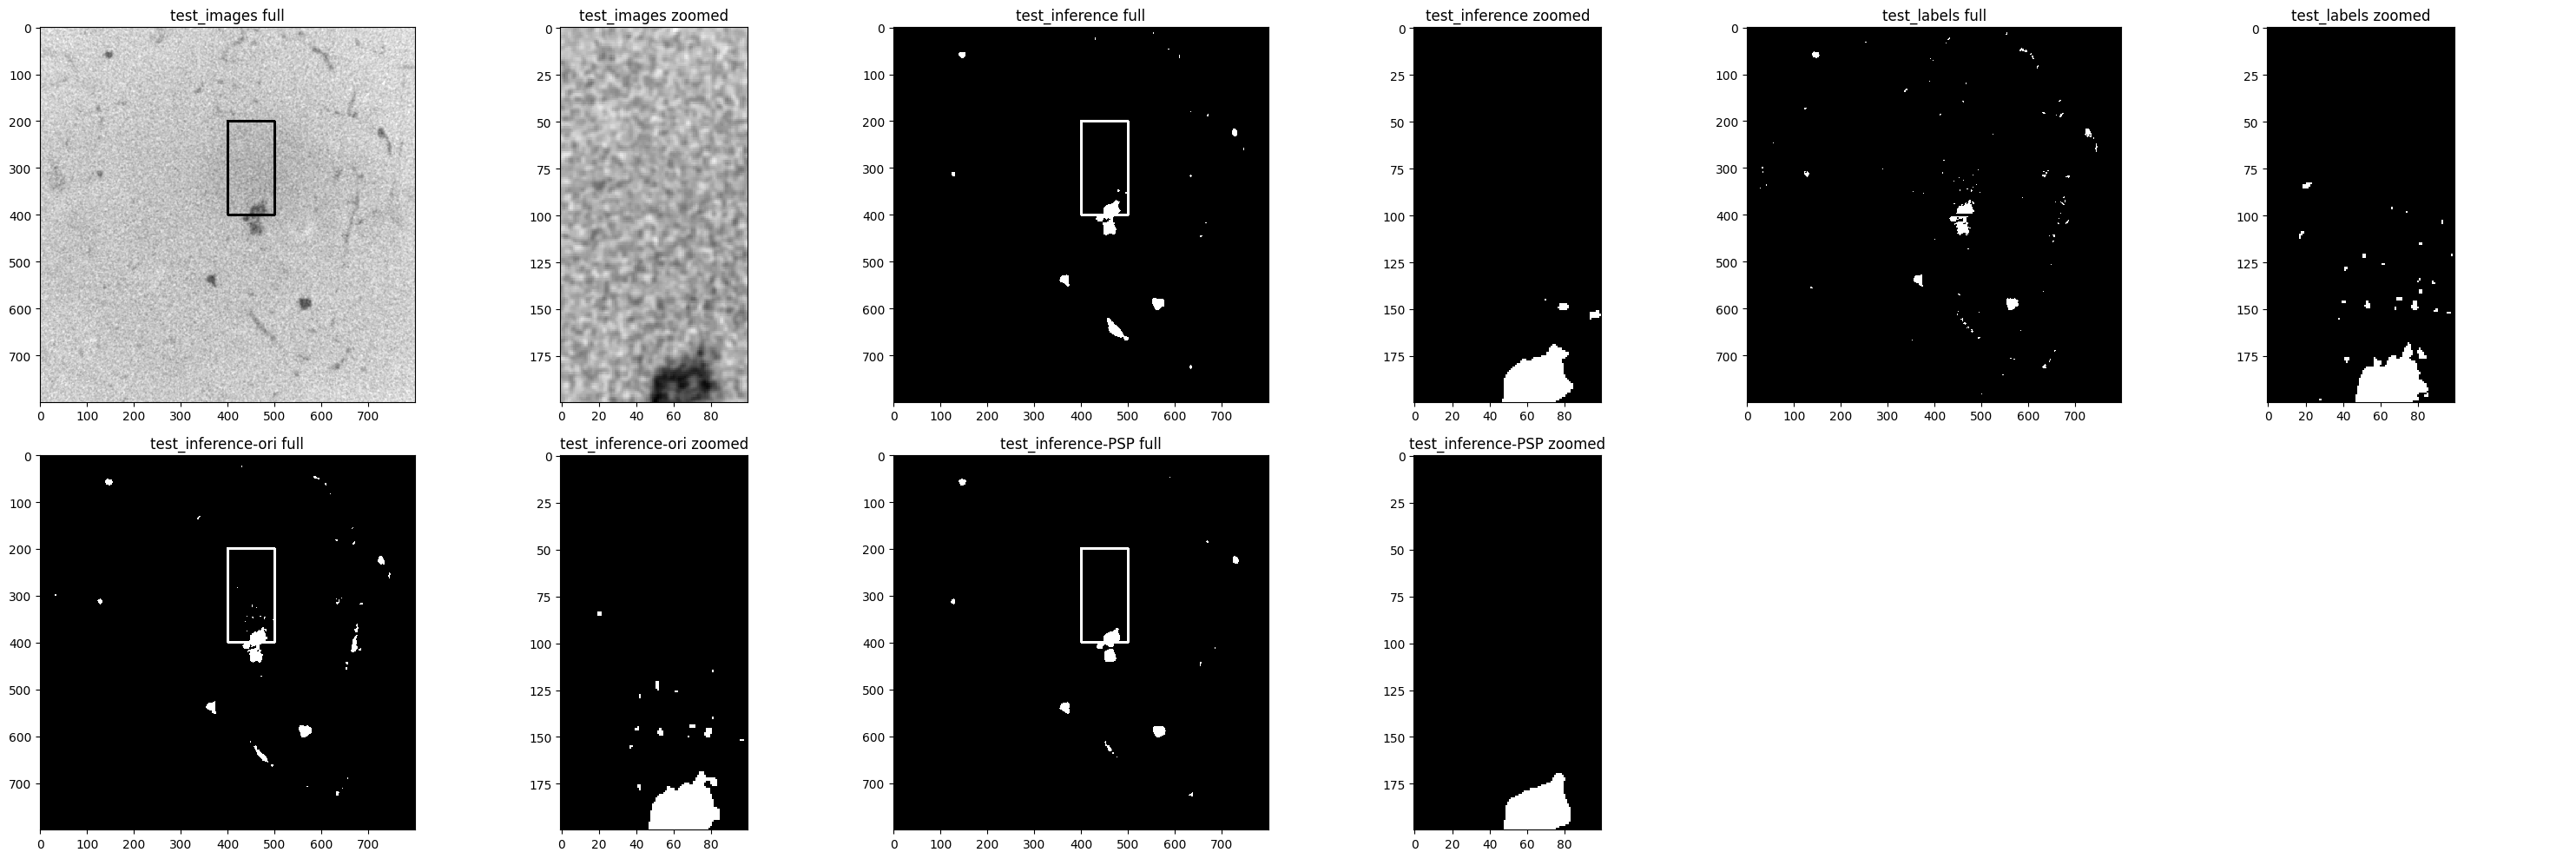

In [17]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference7/', 'test_inference')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/', 'test_inference-ori')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference8/', 'test_inference-PSP')
image_processor = db.get_image_processor('002_ou_DongYing_13636_roi_selected.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', "test_inference-ori", "test_inference-PSP", zoom_region=zoom)